In [ ]:
!pip install xlrd==1.2.0

# Import Statements

In [ ]:
import numpy as np
import pandas as pd
from scipy.linalg import lstsq
from scipy.sparse.linalg import lsmr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, griddata, LinearNDInterpolator, NearestNDInterpolator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split as tts
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from matplotlib import pyplot
import xgboost as xgb
from scipy import linalg

# Setting up kernels and regression/boosted definitions

In [ ]:
# Tricubic Kernel
def Tricubic(x):
  if len(x.shape) == 1:
    x = x.reshape(-1,1)
  d = np.sqrt(np.sum(x**2,axis=1))
  return np.where(d>1,0,70/81*(1-d**3)**3)

# Quartic Kernel
def Quartic(x):
  if len(x.shape) == 1:
    x = x.reshape(-1,1)
  d = np.sqrt(np.sum(x**2,axis=1))
  return np.where(d>1,0,15/16*(1-d**2)**2)

# Epanechnikov Kernel
def Epanechnikov(x):
  if len(x.shape) == 1:
    x = x.reshape(-1,1)
  d = np.sqrt(np.sum(x**2,axis=1))
  return np.where(d>1,0,3/4*(1-d**2)) 

In [ ]:
# Implementing new kernels
# Triangular Kernel
def Triangular(x):
  if len(x.shape) == 1:
    x = x.reshape(-1,1)
  d = np.sqrt(np.sum(x**2,axis=1))
  return np.where(d>1,0,(1-np.abs(d))) 

# Triweight Kernel
def Triweight(x):
  if len(x.shape) == 1:
    x = x.reshape(-1,1)
  d = np.sqrt(np.sum(x**2,axis=1))
  return np.where(d>1,0,35/32*(1-d**2)**3) 


In [ ]:
#Defining the kernel local regression model

def lw_reg(X, y, xnew, kern, tau, intercept):
    n = len(X) 
    yest = np.zeros(n)

    if len(y.shape)==1: 
      y = y.reshape(-1,1)

    if len(X.shape)==1:
      X = X.reshape(-1,1)
    
    if intercept:
      X1 = np.column_stack([np.ones((len(X),1)),X])
    else:
      X1 = X

    w = np.array([kern((X - X[i])/(2*tau)) for i in range(n)]) 

    for i in range(n):          
        W = np.diag(w[:,i])
        b = np.transpose(X1).dot(W).dot(y)
        A = np.transpose(X1).dot(W).dot(X1)
        beta, res, rnk, s = lstsq(A, b)
        yest[i] = np.dot(X1[i],beta)
    if X.shape[1]==1:
      f = interp1d(X.flatten(),yest,fill_value='extrapolate')
    else:
      f = LinearNDInterpolator(X, yest)
    output = f(xnew)
    if sum(np.isnan(output))>0:
      g = NearestNDInterpolator(X,y.ravel()) 
      output[np.isnan(output)] = g(xnew[np.isnan(output)])
    return output

In [ ]:
def boosted_lwr(X, y, xnew, kern, tau, intercept):
  Fx = lw_reg(X,y,X,kern,tau,intercept)
  new_y = y - Fx
  tree_model = DecisionTreeRegressor(max_depth=2, random_state=123)
  tree_model.fit(X,new_y)
  output = tree_model.predict(xnew) + lw_reg(X,y,xnew,kern,tau,intercept) # output = h_i + F(x_i)
  return output 

In [ ]:
scale = StandardScaler()

# Boston Housing Prices

In [ ]:
boston = pd.read_csv('Boston Housing Prices.csv')

In [ ]:
X = boston[['crime','rooms','distance']].values
y = boston['cmedv'].values

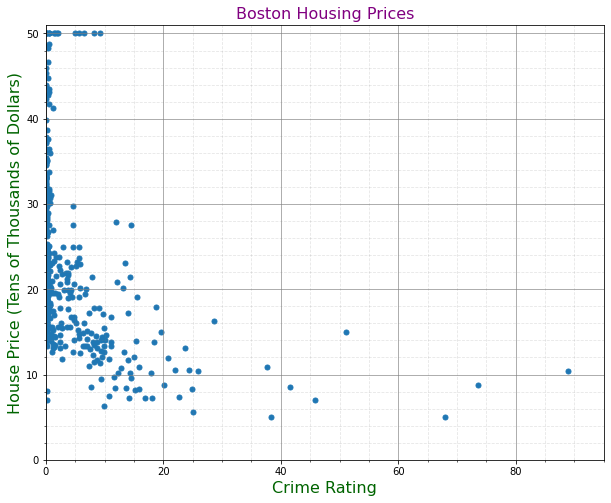

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(0, 95)
ax.set_ylim(0, 51)
ax.scatter(x = boston['crime'], y = boston['cmedv'],s=25)
ax.set_xlabel('Crime Rating',fontsize=16,color='Darkgreen')
ax.set_ylabel('House Price (Tens of Thousands of Dollars)',fontsize=16,color='Darkgreen')
ax.set_title('Boston Housing Prices',fontsize=16,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()

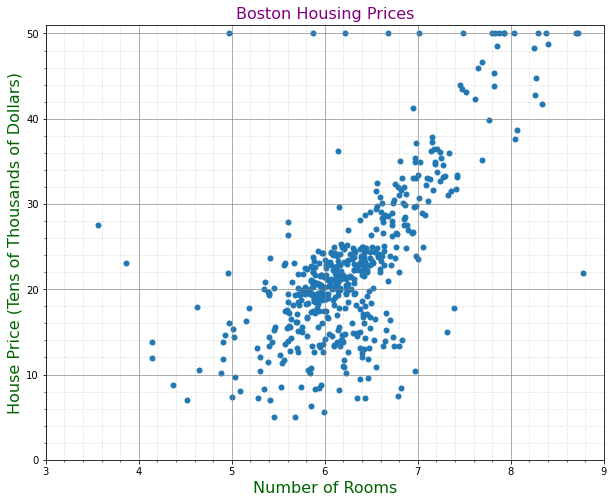

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(3, 9)
ax.set_ylim(0, 51)
ax.scatter(x = boston['rooms'], y = boston['cmedv'],s=25)
ax.set_xlabel('Number of Rooms',fontsize=16,color='Darkgreen')
ax.set_ylabel('House Price (Tens of Thousands of Dollars)',fontsize=16,color='Darkgreen')
ax.set_title('Boston Housing Prices',fontsize=16,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()

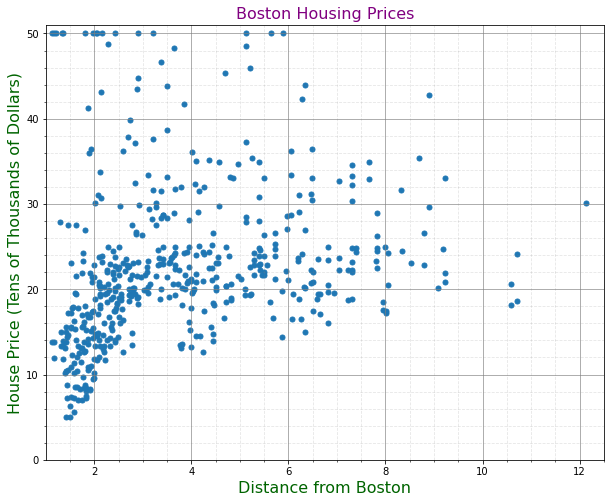

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(1, 12.5)
ax.set_ylim(0, 51)
ax.scatter(x = boston['distance'], y = boston['cmedv'],s=25)
ax.set_xlabel('Distance from Boston',fontsize=16,color='Darkgreen')
ax.set_ylabel('House Price (Tens of Thousands of Dollars)',fontsize=16,color='Darkgreen')
ax.set_title('Boston Housing Prices',fontsize=16,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()

## Best Kernel was triweight or triangular at a tau of 0.5 (will be testing both)

## Testing Kernels, tau = 0.01
Best result was Epanechnikov with an MSE of 32.34672116741398 and an MAE of 3.526820482364922

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_b1 = []
mse_epa_b1 = []
mse_quart_b1 = []
mse_trian_b1 = []
mse_triw_b1 = []
mae_tric_b1 = []
mae_epa_b1 = []
mae_quart_b1 = []
mae_trian_b1 = []
mae_triw_b1 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.01, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.01, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.01, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.01, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 0.01, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 0.01, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 0.01, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 0.01, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 0.01, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 0.01, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_b1.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_b1.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_b1.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_b1.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_b1.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_b1.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_b1.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_b1.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_b1.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_b1.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_b1.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_b1.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_b1.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_b1.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_b1.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_b1.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_b1.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_b1.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_b1.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_b1.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_b1)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_b1)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_b1)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_b1)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_b1)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_b1)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_b1)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_b1)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_b1)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_b1)))

The MSE for LOWESS with the tricubic kernel is: 32.346721167414096
The MSE for LOWESS with the Epanechnikov kernel is: 32.34672116741398
The MSE for LOWESS with the quartic kernel is: 32.34672116741399
The MSE for LOWESS with the triangular kernel is: 32.346721167414024
The MSE for LOWESS with the triweight kernel is: 32.34672116741421


The MAE for LOWESS with the tricubic kernel is: 3.526820482364927
The MAE for LOWESS with the Epanechnikov kernel is: 3.526820482364922
The MAE for LOWESS with the quartic kernel is: 3.526820482364936
The MAE for LOWESS with the triangular kernel is: 3.5268204823649527
The MAE for LOWESS with the triweight kernel is: 3.5268204823649683


## Testing Kernels, tau = 0.05
Best result was Epanechnikov with an MSE of 34.17 and an MAE of 3.486

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_b2 = []
mse_epa_b2 = []
mse_quart_b2 = []
mse_trian_b2 = []
mse_triw_b2 = []
mae_tric_b2 = []
mae_epa_b2 = []
mae_quart_b2 = []
mae_trian_b2 = []
mae_triw_b2 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.05, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.05, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.05, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.05, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 0.05, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 0.05, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 0.05, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 0.05, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 0.05, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 0.05, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_b2.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_b2.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_b2.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_b2.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_b2.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_b2.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_b2.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_b2.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_b2.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_b2.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_b2.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_b2.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_b2.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_b2.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_b2.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_b2.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_b2.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_b2.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_b2.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_b2.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_b2)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_b2)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_b2)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_b2)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_b2)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_b2)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_b2)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_b2)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_b2)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_b2)))

The MSE for LOWESS with the tricubic kernel is: 34.20651441745261
The MSE for LOWESS with the Epanechnikov kernel is: 34.165323072284075
The MSE for LOWESS with the quartic kernel is: 34.19699054476191
The MSE for LOWESS with the triangular kernel is: 34.18188576076685
The MSE for LOWESS with the triweight kernel is: 34.231929590986944


The MAE for LOWESS with the tricubic kernel is: 3.49413949232578
The MAE for LOWESS with the Epanechnikov kernel is: 3.486149070182163
The MAE for LOWESS with the quartic kernel is: 3.492863339496565
The MAE for LOWESS with the triangular kernel is: 3.4899609665464006
The MAE for LOWESS with the triweight kernel is: 3.497671607541501


## Testing Kernels, tau = 0.1
Best result was Epanechnikov with an MSE of 33.55 and an MAE of 3.42



In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_b3 = []
mse_epa_b3 = []
mse_quart_b3 = []
mse_trian_b3 = []
mse_triw_b3 = []
mae_tric_b3 = []
mae_epa_b3 = []
mae_quart_b3 = []
mae_trian_b3 = []
mae_triw_b3 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.1, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.1, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.1, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.1, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 0.1, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 0.1, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 0.1, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 0.1, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 0.1, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 0.1, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_b3.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_b3.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_b3.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_b3.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_b3.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_b3.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_b3.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_b3.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_b3.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_b3.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_b3.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_b3.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_b3.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_b3.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_b3.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_b3.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_b3.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_b3.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_b3.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_b3.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_b3)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_b3)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_b3)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_b3)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_b3)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_b3)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_b3)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_b3)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_b3)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_b3)))

The MSE for LOWESS with the tricubic kernel is: 33.68216774135722
The MSE for LOWESS with the Epanechnikov kernel is: 33.54627307757748
The MSE for LOWESS with the quartic kernel is: 33.664742251924444
The MSE for LOWESS with the triangular kernel is: 33.62118285351454
The MSE for LOWESS with the triweight kernel is: 33.80004009423044


The MAE for LOWESS with the tricubic kernel is: 3.4443112463095718
The MAE for LOWESS with the Epanechnikov kernel is: 3.4206578754134247
The MAE for LOWESS with the quartic kernel is: 3.439935113811443
The MAE for LOWESS with the triangular kernel is: 3.431537283547061
The MAE for LOWESS with the triweight kernel is: 3.4599782971059367


## Testing Kernels, tau = 0.5
Best result was triangular with an MSE of 30.73 and an MAE of 3.326; or triweight with an MSE of 30.96 and an MAE of 3.31

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_b4 = []
mse_epa_b4 = []
mse_quart_b4 = []
mse_trian_b4 = []
mse_triw_b4 = []
mae_tric_b4 = []
mae_epa_b4 = []
mae_quart_b4 = []
mae_trian_b4 = []
mae_triw_b4 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.5, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.5, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.5, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.5, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 0.5, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 0.5, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 0.5, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 0.5, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 0.5, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 0.5, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_b4.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_b4.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_b4.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_b4.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_b4.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_b4.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_b4.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_b4.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_b4.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_b4.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_b4.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_b4.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_b4.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_b4.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_b4.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_b4.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_b4.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_b4.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_b4.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_b4.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_b4)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_b4)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_b4)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_b4)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_b4)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_b4)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_b4)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_b4)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_b4)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_b4)))

The MSE for LOWESS with the tricubic kernel is: 30.91943989065685
The MSE for LOWESS with the Epanechnikov kernel is: 30.9113353059855
The MSE for LOWESS with the quartic kernel is: 30.816160492018508
The MSE for LOWESS with the triangular kernel is: 30.727024789237106
The MSE for LOWESS with the triweight kernel is: 30.959123220693442


The MAE for LOWESS with the tricubic kernel is: 3.3265950682484076
The MAE for LOWESS with the Epanechnikov kernel is: 3.3558088111337794
The MAE for LOWESS with the quartic kernel is: 3.318060644445145
The MAE for LOWESS with the triangular kernel is: 3.325910714332506
The MAE for LOWESS with the triweight kernel is: 3.3108924979228838


## Testing Kernels, tau = 1
Best result was triweight with an MSE of 30.99 and an MAE of 3.39

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_b5 = []
mse_epa_b5 = []
mse_quart_b5 = []
mse_trian_b5 = []
mse_triw_b5 = []
mae_tric_b5 = []
mae_epa_b5 = []
mae_quart_b5 = []
mae_trian_b5 = []
mae_triw_b5 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 1, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 1, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 1, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 1, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 1, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 1, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 1, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 1, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 1, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 1, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_b5.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_b5.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_b5.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_b5.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_b5.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_b5.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_b5.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_b5.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_b5.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_b5.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_b5.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_b5.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_b5.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_b5.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_b5.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_b5.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_b5.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_b5.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_b5.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_b5.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_b5)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_b5)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_b5)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_b5)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_b5)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_b5)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_b5)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_b5)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_b5)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_b5)))

The MSE for LOWESS with the tricubic kernel is: 31.289441989267004
The MSE for LOWESS with the Epanechnikov kernel is: 31.609336929687725
The MSE for LOWESS with the quartic kernel is: 31.226789530114832
The MSE for LOWESS with the triangular kernel is: 31.316683385904618
The MSE for LOWESS with the triweight kernel is: 30.992979746523027


The MAE for LOWESS with the tricubic kernel is: 3.418946171751793
The MAE for LOWESS with the Epanechnikov kernel is: 3.4601681588556468
The MAE for LOWESS with the quartic kernel is: 3.4125033331658843
The MAE for LOWESS with the triangular kernel is: 3.4263434944030386
The MAE for LOWESS with the triweight kernel is: 3.387549963237543


## Testing Kernels, tau = 1.25
Best result was triweight with an MSE of 31.32 and an MAE of 3.43

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_b6 = []
mse_epa_b6 = []
mse_quart_b6 = []
mse_trian_b6 = []
mse_triw_b6 = []
mae_tric_b6 = []
mae_epa_b6 = []
mae_quart_b6 = []
mae_trian_b6 = []
mae_triw_b6 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 1.25, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 1.25, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 1.25, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 1.25, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 1.25, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 1.25, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 1.25, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 1.25, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 1.25, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 1.25, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_b6.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_b6.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_b6.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_b6.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_b6.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_b6.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_b6.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_b6.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_b6.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_b6.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_b6.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_b6.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_b6.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_b6.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_b6.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_b6.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_b6.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_b6.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_b6.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_b6.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_b6)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_b6)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_b6)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_b6)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_b6)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_b6)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_b6)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_b6)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_b6)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_b6)))

The MSE for LOWESS with the tricubic kernel is: 31.65425857821245
The MSE for LOWESS with the Epanechnikov kernel is: 32.005389561388405
The MSE for LOWESS with the quartic kernel is: 31.567818526882256
The MSE for LOWESS with the triangular kernel is: 31.658852506755473
The MSE for LOWESS with the triweight kernel is: 31.322981286196427


The MAE for LOWESS with the tricubic kernel is: 3.4724951937949804
The MAE for LOWESS with the Epanechnikov kernel is: 3.525360961302151
The MAE for LOWESS with the quartic kernel is: 3.46474205765119
The MAE for LOWESS with the triangular kernel is: 3.4825474244475636
The MAE for LOWESS with the triweight kernel is: 3.42809127887618


## Testing Kernels, tau = 1.5
Best result was triweight with an MSE of 31.61 and an MAE of 3.47

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_b7 = []
mse_epa_b7 = []
mse_quart_b7 = []
mse_trian_b7 = []
mse_triw_b7 = []
mae_tric_b7 = []
mae_epa_b7 = []
mae_quart_b7 = []
mae_trian_b7 = []
mae_triw_b7 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 1.5, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 1.5, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 1.5, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 1.5, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 1.5, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 1.5, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 1.5, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 1.5, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 1.5, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 1.5, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_b7.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_b7.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_b7.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_b7.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_b7.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_b7.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_b7.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_b7.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_b7.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_b7.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_b7.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_b7.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_b7.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_b7.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_b7.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_b7.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_b7.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_b7.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_b7.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_b7.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_b7)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_b7)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_b7)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_b7)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_b7)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_b7)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_b7)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_b7)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_b7)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_b7)))

The MSE for LOWESS with the tricubic kernel is: 32.02327759605817
The MSE for LOWESS with the Epanechnikov kernel is: 32.53625323735775
The MSE for LOWESS with the quartic kernel is: 31.921797571929964
The MSE for LOWESS with the triangular kernel is: 32.068686124398084
The MSE for LOWESS with the triweight kernel is: 31.611337373904643


The MAE for LOWESS with the tricubic kernel is: 3.525876627483593
The MAE for LOWESS with the Epanechnikov kernel is: 3.584665847745071
The MAE for LOWESS with the quartic kernel is: 3.5141751231657965
The MAE for LOWESS with the triangular kernel is: 3.5326501239642583
The MAE for LOWESS with the triweight kernel is: 3.472696146951537


## Testing Kernels, tau = 2
Best result was triweight with an MSE of 32.35 and an MAE of 3.55

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_b8 = []
mse_epa_b8 = []
mse_quart_b8 = []
mse_trian_b8 = []
mse_triw_b8 = []
mae_tric_b8 = []
mae_epa_b8 = []
mae_quart_b8 = []
mae_trian_b8 = []
mae_triw_b8 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 2, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 2, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 2, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 2, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 2, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 2, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 2, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 2, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 2, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 2, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_b8.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_b8.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_b8.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_b8.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_b8.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_b8.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_b8.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_b8.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_b8.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_b8.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_b8.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_b8.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_b8.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_b8.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_b8.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_b8.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_b8.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_b8.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_b8.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_b8.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_b8)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_b8)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_b8)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_b8)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_b8)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_b8)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_b8)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_b8)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_b8)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_b8)))

The MSE for LOWESS with the tricubic kernel is: 33.07263261150238
The MSE for LOWESS with the Epanechnikov kernel is: 34.012971112475356
The MSE for LOWESS with the quartic kernel is: 32.932859373661024
The MSE for LOWESS with the triangular kernel is: 33.23667336922581
The MSE for LOWESS with the triweight kernel is: 32.3472483506115


The MAE for LOWESS with the tricubic kernel is: 3.621705316477012
The MAE for LOWESS with the Epanechnikov kernel is: 3.679748209761995
The MAE for LOWESS with the quartic kernel is: 3.6013150114689894
The MAE for LOWESS with the triangular kernel is: 3.6142677790136717
The MAE for LOWESS with the triweight kernel is: 3.5521411843796713


## Testing XGB
Best result was 1000 trees and a lambda of 10; or 1000 trees, lambda of 10, and an alpha of 5; with an MSE of 23.120172091199883 (will be testing both)

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_100 = []
mse_1000 = []
mse_100_l10 = []
mse_1000_l10 = []
mse_100_l50 = []
mse_1000_l50 = []
mse_100_d5 = []
mse_1000_d5 = []
mse_100_l10_d5 = []
mse_1000_l10_d5 = []
mse_100_l50_d5 = []
mse_1000_l50_d5 = []
mse_100_a5 = []
mse_1000_a5 = []
mse_100_l10_a5 = []
mse_1000_l10_a5 = []
mse_100_l50_a5 = []
mse_1000_l50_a5 = []
mse_100_d5_a5 = []
mse_1000_d5_a5 = []
mse_100_l10_d5_a5 = []
mse_1000_l10_d5_a5 = []
mse_100_l50_d5_a5 = []
mse_1000_l50_d5_a5 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  model_xgb_1 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=20,alpha=1,gamma=10,max_depth=3)
  model_xgb_1.fit(xtrain,ytrain)
  yhat_xgb_1 = model_xgb_1.predict(xtest)

  model_xgb_2 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=20,alpha=1,gamma=10,max_depth=3)
  model_xgb_2.fit(xtrain,ytrain)
  yhat_xgb_2 = model_xgb_2.predict(xtest)

  model_xgb_3 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=10,alpha=1,gamma=10,max_depth=3)
  model_xgb_3.fit(xtrain,ytrain)
  yhat_xgb_3 = model_xgb_3.predict(xtest)

  model_xgb_4 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=10,alpha=1,gamma=10,max_depth=3)
  model_xgb_4.fit(xtrain,ytrain)
  yhat_xgb_4 = model_xgb_4.predict(xtest)

  model_xgb_5 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=50,alpha=1,gamma=10,max_depth=3)
  model_xgb_5.fit(xtrain,ytrain)
  yhat_xgb_5 = model_xgb_5.predict(xtest)

  model_xgb_6 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=50,alpha=1,gamma=10,max_depth=3)
  model_xgb_6.fit(xtrain,ytrain)
  yhat_xgb_6 = model_xgb_6.predict(xtest)

  model_xgb_7 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=20,alpha=1,gamma=10,max_depth=5)
  model_xgb_7.fit(xtrain,ytrain)
  yhat_xgb_7 = model_xgb_7.predict(xtest)

  model_xgb_8 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=20,alpha=1,gamma=10,max_depth=5)
  model_xgb_8.fit(xtrain,ytrain)
  yhat_xgb_8 = model_xgb_8.predict(xtest)

  model_xgb_9 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=10,alpha=1,gamma=10,max_depth=5)
  model_xgb_9.fit(xtrain,ytrain)
  yhat_xgb_9 = model_xgb_9.predict(xtest)

  model_xgb_10 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=10,alpha=1,gamma=10,max_depth=5)
  model_xgb_10.fit(xtrain,ytrain)
  yhat_xgb_10 = model_xgb_10.predict(xtest)

  model_xgb_11 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=50,alpha=1,gamma=10,max_depth=5)
  model_xgb_11.fit(xtrain,ytrain)
  yhat_xgb_11 = model_xgb_11.predict(xtest)

  model_xgb_12 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=50,alpha=1,gamma=10,max_depth=5)
  model_xgb_12.fit(xtrain,ytrain)
  yhat_xgb_12 = model_xgb_12.predict(xtest)

  model_xgb_13 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=20,alpha=5,gamma=10,max_depth=3)
  model_xgb_13.fit(xtrain,ytrain)
  yhat_xgb_13 = model_xgb_13.predict(xtest)

  model_xgb_14 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=20,alpha=5,gamma=10,max_depth=3)
  model_xgb_14.fit(xtrain,ytrain)
  yhat_xgb_14 = model_xgb_14.predict(xtest)

  model_xgb_15 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=10,alpha=5,gamma=10,max_depth=3)
  model_xgb_15.fit(xtrain,ytrain)
  yhat_xgb_15 = model_xgb_15.predict(xtest)

  model_xgb_16 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=10,alpha=5,gamma=10,max_depth=3)
  model_xgb_16.fit(xtrain,ytrain)
  yhat_xgb_16 = model_xgb_16.predict(xtest)

  model_xgb_17 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=50,alpha=5,gamma=10,max_depth=3)
  model_xgb_17.fit(xtrain,ytrain)
  yhat_xgb_17 = model_xgb_17.predict(xtest)

  model_xgb_18 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=50,alpha=5,gamma=10,max_depth=3)
  model_xgb_18.fit(xtrain,ytrain)
  yhat_xgb_18 = model_xgb_18.predict(xtest)

  model_xgb_19 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=20,alpha=5,gamma=10,max_depth=5)
  model_xgb_19.fit(xtrain,ytrain)
  yhat_xgb_19 = model_xgb_19.predict(xtest)

  model_xgb_20 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=20,alpha=5,gamma=10,max_depth=5)
  model_xgb_20.fit(xtrain,ytrain)
  yhat_xgb_20 = model_xgb_20.predict(xtest)

  model_xgb_21 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=10,alpha=5,gamma=10,max_depth=5)
  model_xgb_21.fit(xtrain,ytrain)
  yhat_xgb_21 = model_xgb_21.predict(xtest)

  model_xgb_22 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=10,alpha=5,gamma=10,max_depth=5)
  model_xgb_22.fit(xtrain,ytrain)
  yhat_xgb_22 = model_xgb_22.predict(xtest)

  model_xgb_23 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=50,alpha=5,gamma=10,max_depth=5)
  model_xgb_23.fit(xtrain,ytrain)
  yhat_xgb_23 = model_xgb_23.predict(xtest)

  model_xgb_24 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=50,alpha=5,gamma=10,max_depth=5)
  model_xgb_24.fit(xtrain,ytrain)
  yhat_xgb_24 = model_xgb_24.predict(xtest)

  mse_100.append(mse(ytest,yhat_xgb_1))
  mse_1000.append(mse(ytest,yhat_xgb_2))

  mse_100_l10.append(mse(ytest,yhat_xgb_3))
  mse_1000_l10.append(mse(ytest,yhat_xgb_4))

  mse_100_l50.append(mse(ytest,yhat_xgb_5))
  mse_1000_l50.append(mse(ytest,yhat_xgb_6))

  mse_100_d5.append(mse(ytest,yhat_xgb_7))
  mse_1000_d5.append(mse(ytest,yhat_xgb_8))

  mse_100_l10_d5.append(mse(ytest,yhat_xgb_9))
  mse_1000_l10_d5.append(mse(ytest,yhat_xgb_10))

  mse_100_l50_d5.append(mse(ytest,yhat_xgb_11))
  mse_1000_l50_d5.append(mse(ytest,yhat_xgb_12))

  mse_100_a5.append(mse(ytest,yhat_xgb_13))
  mse_1000_a5.append(mse(ytest,yhat_xgb_14))

  mse_100_l10_a5.append(mse(ytest,yhat_xgb_15))
  mse_1000_l10_a5.append(mse(ytest,yhat_xgb_16))

  mse_100_l50_a5.append(mse(ytest,yhat_xgb_17))
  mse_1000_l50_a5.append(mse(ytest,yhat_xgb_18))

  mse_100_d5_a5.append(mse(ytest,yhat_xgb_19))
  mse_1000_d5_a5.append(mse(ytest,yhat_xgb_20))

  mse_100_l10_d5_a5.append(mse(ytest,yhat_xgb_21))
  mse_1000_l10_d5_a5.append(mse(ytest,yhat_xgb_22))

  mse_100_l50_d5_a5.append(mse(ytest,yhat_xgb_23))
  mse_1000_l50_d5_a5.append(mse(ytest,yhat_xgb_24))

print("The MSE for 100 trees is: " + str(np.mean(mse_100)))
print("The MSE for 1000 trees is: " + str(np.mean(mse_1000)))

print("The MSE for 100 trees and a lambda of 10 is: " + str(np.mean(mse_100_l10)))
print("The MSE for 1000 trees and a lambda of 10 is: " + str(np.mean(mse_1000_l10)))

print("The MSE for 100 trees and a lambda of 50 is: " + str(np.mean(mse_100_l50)))
print("The MSE for 1000 trees and a lambda of 50 is: " + str(np.mean(mse_1000_l50)))

print("The MSE for 100 trees and a depth of 5 is: " + str(np.mean(mse_100_d5)))
print("The MSE for 1000 trees and a depth of 5 is: " + str(np.mean(mse_1000_d5)))

print("The MSE for 100 trees, depth of 5, and a lambda of 10 is: " + str(np.mean(mse_100_l10_d5)))
print("The MSE for 1000 trees, depth of 5, and a lambda of 10 is: " + str(np.mean(mse_1000_l10_d5)))

print("The MSE for 100 trees, depth of 5, and a lambda of 50 is: " + str(np.mean(mse_100_l50_d5)))
print("The MSE for 1000 trees, depth of 5, and a lambda of 50 is: " + str(np.mean(mse_1000_l50_d5)))

print("The MSE for 100 tres and an alpha of 5 is: " + str(np.mean(mse_100_a5)))
print("The MSE for 1000 trees and an alpha of 5 is: " + str(np.mean(mse_1000_a5)))

print("The MSE for 100 trees, lambda of 10, and an alpha of 5 is: " + str(np.mean(mse_100_l10_a5)))
print("The MSE for 1000 trees, lambda of 10, and an alpha of 5 is: " + str(np.mean(mse_1000_l10_a5)))

print("The MSE for 100 trees, lambda of 50, and an alpha of 5 is: " + str(np.mean(mse_100_l50_a5)))
print("The MSE for 1000 trees, lambda of 50, and an alpha of 5 is: " + str(np.mean(mse_1000_l50_a5)))

print("The MSE for 100 trees, depth of 5, and an alpha of 5 is: " + str(np.mean(mse_100_d5_a5)))
print("The MSE for 1000 trees, depth of 5, and an alpha of 5 is: " + str(np.mean(mse_1000_d5_a5)))

print("The MSE for 100 trees, lambda of 10, depth of 5, and an alpha of 5 is: " + str(np.mean(mse_100_l10_d5_a5)))
print("The MSE for 1000 trees, lambda of 10, depth of 5, and an alpha of 5 is: " + str(np.mean(mse_1000_l10_d5_a5)))

print("The MSE for 100 trees, lambda of 50, depth of 5, and an alpha of 5 is: " + str(np.mean(mse_100_l50_d5_a5)))
print("The MSE for 1000 trees, lambda of 50, depth of 5, and an alpha of 5 is: " + str(np.mean(mse_1000_l50_d5_a5)))

The MSE for 100 trees is: 23.84028577167323
The MSE for 1000 trees is: 23.6923033827836
The MSE for 100 trees and a lambda of 10 is: 23.25706058817645
The MSE for 1000 trees and a lambda of 10 is: 23.120172091199883
The MSE for 100 trees and a lambda of 50 is: 24.932710810655358
The MSE for 1000 trees and a lambda of 50 is: 24.578586808258994
The MSE for 100 trees and a depth of 5 is: 23.986509170332393
The MSE for 1000 trees and a depth of 5 is: 23.877359696356415
The MSE for 100 trees, depth of 5, and a lambda of 10 is: 23.809119316364523
The MSE for 1000 trees, depth of 5, and a lambda of 10 is: 23.781086553079938
The MSE for 100 trees, depth of 5, and a lambda of 50 is: 24.147887516425094
The MSE for 1000 trees, depth of 5, and a lambda of 50 is: 23.95620647994629
The MSE for 100 tres and an alpha of 5 is: 23.84028577167323
The MSE for 1000 trees and an alpha of 5 is: 23.6923033827836
The MSE for 100 trees, lambda of 10, and an alpha of 5 is: 23.25706058817645
The MSE for 1000 tree

## Testing boosted
XGB won with an MSE of 22.04 and an MAE of 3.12

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=1234)

In [ ]:
mse_lwr1_T = []
mse_lwr1_F = []
mse_lwr2_T = []
mse_lwr2_F = []
mse_blwr1_T = []
mse_blwr1_F = []
mse_blwr2_T = []
mse_blwr2_F = []
mse_xgb_1 = []
mse_xgb_2 = []

mae_lwr1_T = []
mae_lwr2_T = []
mae_lwr1_F = []
mae_lwr2_F = []
mae_blwr1_T = []
mae_blwr2_T = []
mae_blwr1_F = []
mae_blwr2_F = []
mae_xgb_1 = []
mae_xgb_2 = []

for i in range(100):
  kf = KFold(n_splits=10,shuffle=True,random_state=i)
  for idxtrain, idxtest in kf.split(X):
    xtrain = X[idxtrain]
    ytrain = y[idxtrain]
    ytest = y[idxtest]
    xtest = X[idxtest]

    xtrain = scale.fit_transform(xtrain)
    xtest = scale.transform(xtest)

    yhat_lwr1_T = lw_reg(xtrain,ytrain, xtest,Triweight,tau=0.5,intercept=True)
    yhat_lwr1_F = lw_reg(xtrain,ytrain, xtest,Triweight,tau=0.5,intercept=False)
    yhat_lwr2_T = lw_reg(xtrain,ytrain, xtest,Triangular,tau=0.5,intercept=True)
    yhat_lwr2_F = lw_reg(xtrain,ytrain, xtest,Triangular,tau=0.5,intercept=False)
    yhat_blwr1_T = boosted_lwr(xtrain,ytrain, xtest,Triweight,tau=0.5,intercept=True)
    yhat_blwr1_F = boosted_lwr(xtrain,ytrain, xtest,Triweight,tau=0.5,intercept=False)
    yhat_blwr2_T = boosted_lwr(xtrain,ytrain, xtest,Triangular,tau=0.5,intercept=True)
    yhat_blwr2_F = boosted_lwr(xtrain,ytrain, xtest,Triangular,tau=0.5,intercept=False)
    model_xgb_1 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=10,alpha=1,gamma=10,max_depth=3)
    model_xgb_1.fit(xtrain,ytrain)
    yhat_xgb_1 = model_xgb_1.predict(xtest)
    model_xgb_2 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=10,alpha=5,gamma=10,max_depth=3)
    model_xgb_2.fit(xtrain,ytrain)
    yhat_xgb_2 = model_xgb_2.predict(xtest)

    mse_lwr1_T.append(mse(ytest,yhat_lwr1_T))
    mse_lwr1_F.append(mse(ytest,yhat_lwr1_F))
    mse_lwr2_T.append(mse(ytest,yhat_lwr2_T))
    mse_lwr2_F.append(mse(ytest,yhat_lwr2_F))
    mse_blwr1_T.append(mse(ytest,yhat_blwr1_T))
    mse_blwr1_F.append(mse(ytest,yhat_blwr1_F))
    mse_blwr2_T.append(mse(ytest,yhat_blwr2_T))
    mse_blwr2_F.append(mse(ytest,yhat_blwr2_F))
    mse_xgb_1.append(mse(ytest, yhat_xgb_1))
    mse_xgb_2.append(mse(ytest, yhat_xgb_2))

    mae_lwr1_T.append(mae(ytest,yhat_lwr1_T))
    mae_lwr1_F.append(mae(ytest,yhat_lwr1_F))
    mae_lwr2_T.append(mae(ytest,yhat_lwr2_T))
    mae_lwr2_F.append(mae(ytest,yhat_lwr2_F))
    mae_blwr1_T.append(mae(ytest,yhat_blwr1_T))
    mae_blwr1_F.append(mae(ytest,yhat_blwr1_F))
    mae_blwr2_T.append(mae(ytest,yhat_blwr2_T))
    mae_blwr2_F.append(mae(ytest,yhat_blwr2_F))
    mae_xgb_1.append(mae(ytest, yhat_xgb_1))
    mae_xgb_2.append(mae(ytest, yhat_xgb_2))

print('The Cross-validated Mean Squared Error for triweight LWR with intercept is : ' + str(np.mean(mse_lwr1_T)))
print('The Cross-validated Mean Squared Error for triangular LWR with intercept is : ' + str(np.mean(mse_lwr2_T)))
print('The Cross-validated Mean Squared Error for triweight BLWR with intercept is : '+str(np.mean(mse_blwr1_T)))
print('The Cross-validated Mean Squared Error for triangular BLWR with intercept is : '+str(np.mean(mse_blwr2_T)))
print('The Cross-validated Mean Squared Error for XGB with 1000 trees and alpha of 1 is : '+str(np.mean(mse_xgb_1)))
print('The Cross-validated Mean Squared Error for XGB with 1000 trees and alpha of 5 is : '+str(np.mean(mse_xgb_2)))
print('The Cross-validated Mean Squared Error for triweight LWR without intercept is : ' + str(np.mean(mse_lwr1_F)))
print('The Cross-validated Mean Squared Error for triangular LWR without intercept is : ' + str(np.mean(mse_lwr2_F)))
print('The Cross-validated Mean Squared Error for triweight BLWR without intercept is : '+str(np.mean(mse_blwr1_F)))
print('The Cross-validated Mean Squared Error for triangular BLWR without intercept is : '+str(np.mean(mse_blwr2_F)))
print('\n')
print('The Cross-validated Mean Absolute Error for triweight LWR with intercept is : ' + str(np.mean(mae_lwr1_T)))
print('The Cross-validated Mean Absolute Error for triangular LWR with intercept is : ' + str(np.mean(mae_lwr2_T)))
print('The Cross-validated Mean Absolute Error for triweight BLWR with intercept is : '+str(np.mean(mae_blwr1_T)))
print('The Cross-validated Mean Absolute Error for triangular BLWR with intercept is : '+str(np.mean(mae_blwr2_T)))
print('The Cross-validated Mean Absolute Error for XGB with 1000 trees and alpha of 1 is : '+str(np.mean(mae_xgb_1)))
print('The Cross-validated Mean Absolute Error for XGB with 1000 trees and alpha of 5 is : '+str(np.mean(mae_xgb_2)))
print('The Cross-validated Mean Absolute Error for triweight LWR without intercept is : ' + str(np.mean(mae_lwr1_F)))
print('The Cross-validated Mean Absolute Error for triangular LWR without intercept is : ' + str(np.mean(mae_lwr2_F)))
print('The Cross-validated Mean Absolute Error for triweight BLWR without intercept is : '+str(np.mean(mae_blwr1_F)))
print('The Cross-validated Mean Absolute Error for triangular BLWR without intercept is : '+str(np.mean(mae_blwr2_F)))

The Cross-validated Mean Squared Error for triweight LWR with intercept is : 27.06900603942958
The Cross-validated Mean Squared Error for triangular LWR with intercept is : 27.086429616693074
The Cross-validated Mean Squared Error for triweight BLWR with intercept is : 26.59135713519854
The Cross-validated Mean Squared Error for triangular BLWR with intercept is : 27.593497550985486
The Cross-validated Mean Squared Error for XGB with 1000 trees and alpha of 1 is : 22.043323138533495
The Cross-validated Mean Squared Error for XGB with 1000 trees and alpha of 5 is : 22.043323138533495
The Cross-validated Mean Squared Error for triweight LWR without intercept is : 30.09489822904585
The Cross-validated Mean Squared Error for triangular LWR without intercept is : 32.38267146347681
The Cross-validated Mean Squared Error for triweight BLWR without intercept is : 30.412304579455675
The Cross-validated Mean Squared Error for triangular BLWR without intercept is : 32.922965409257245


The Cross-

# Cars Dataset

In [ ]:
cars = pd.read_csv('cars.csv')

In [ ]:
X = cars[['ENG', 'CYL', 'WGT']].values
y = cars['MPG'].values

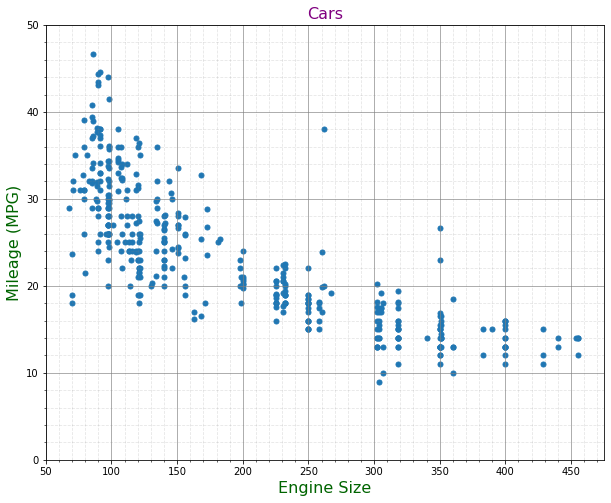

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(50, 475)
ax.set_ylim(0, 50)
ax.scatter(x = cars['ENG'], y = cars['MPG'],s=25)
ax.set_xlabel('Engine Size',fontsize=16,color='Darkgreen')
ax.set_ylabel('Mileage (MPG)',fontsize=16,color='Darkgreen')
ax.set_title('Cars',fontsize=16,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()

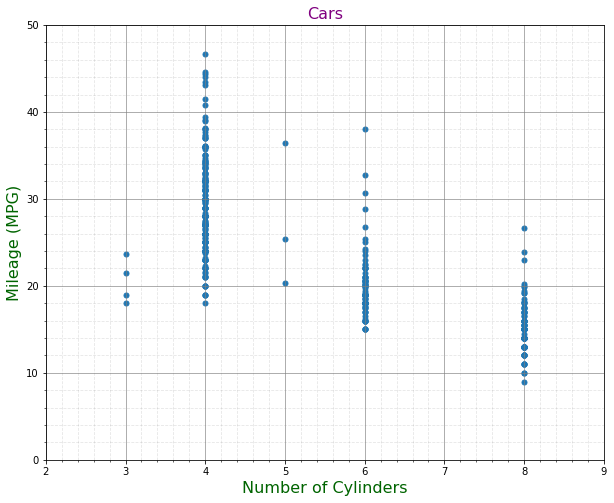

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(2, 9)
ax.set_ylim(0, 50)
ax.scatter(x = cars['CYL'], y = cars['MPG'],s=25)
ax.set_xlabel('Number of Cylinders',fontsize=16,color='Darkgreen')
ax.set_ylabel('Mileage (MPG)',fontsize=16,color='Darkgreen')
ax.set_title('Cars',fontsize=16,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()

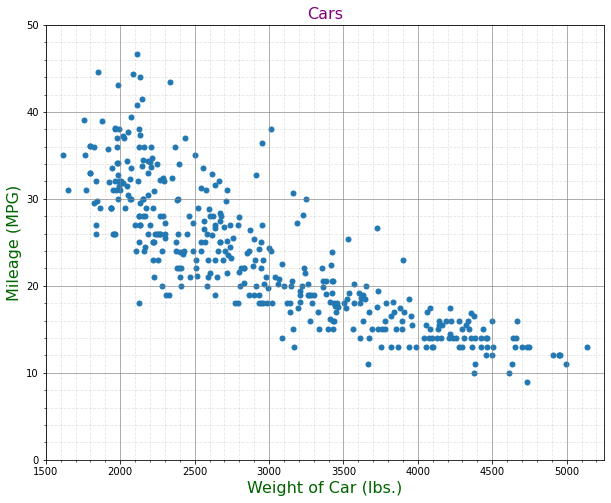

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(1500, 5250)
ax.set_ylim(0, 50)
ax.scatter(x = cars['WGT'], y = cars['MPG'],s=25)
ax.set_xlabel('Weight of Car (lbs.)',fontsize=16,color='Darkgreen')
ax.set_ylabel('Mileage (MPG)',fontsize=16,color='Darkgreen')
ax.set_title('Cars',fontsize=16,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()

## Best Kernel was triangular and tau of 0.5 with an MSE of 16.95 and an MAE of 3.006; or Epanechnikov and tau of 0.5 with an MSE of 16.96 and an MAE of 3.005 (will be testing both)

## Testing Kernels, tau = 0.01
Best result was Epanechnikov with an MSE of 21.07 and an MAE of 3.276

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_c1 = []
mse_epa_c1 = []
mse_quart_c1 = []
mse_trian_c1 = []
mse_triw_c1 = []
mae_tric_c1 = []
mae_epa_c1 = []
mae_quart_c1 = []
mae_trian_c1 = []
mae_triw_c1 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]

  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.01, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.01, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.01, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.01, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 0.01, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 0.01, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 0.01, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 0.01, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 0.01, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 0.01, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_c1.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_c1.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_c1.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_c1.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_c1.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_c1.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_c1.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_c1.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_c1.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_c1.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_c1.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_c1.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_c1.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_c1.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_c1.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_c1.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_c1.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_c1.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_c1.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_c1.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_c1)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_c1)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_c1)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_c1)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_c1)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_c1)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_c1)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_c1)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_c1)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_c1)))

The MSE for LOWESS with the tricubic kernel is: 21.19747143999255
The MSE for LOWESS with the Epanechnikov kernel is: 21.073941096811314
The MSE for LOWESS with the quartic kernel is: 21.18043791013109
The MSE for LOWESS with the triangular kernel is: 21.133322801799018
The MSE for LOWESS with the triweight kernel is: 21.23365079589592


The MAE for LOWESS with the tricubic kernel is: 3.2858897926737862
The MAE for LOWESS with the Epanechnikov kernel is: 3.2763713591845587
The MAE for LOWESS with the quartic kernel is: 3.2850373296368742
The MAE for LOWESS with the triangular kernel is: 3.2809338344339567
The MAE for LOWESS with the triweight kernel is: 3.2883994237096488


## Testing Kernels, tau = 0.05
Best result was triangular with an MSE of 18.6383 and an MAE of 3.128; or triweight with an MSE of 18.80 and and MAE of 3.1227

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_c2 = []
mse_epa_c2 = []
mse_quart_c2 = []
mse_trian_c2 = []
mse_triw_c2 = []
mae_tric_c2 = []
mae_epa_c2 = []
mae_quart_c2 = []
mae_trian_c2 = []
mae_triw_c2 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.05, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.05, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.05, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.05, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 0.05, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 0.05, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 0.05, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 0.05, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 0.05, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 0.05, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_c2.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_c2.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_c2.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_c2.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_c2.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_c2.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_c2.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_c2.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_c2.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_c2.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_c2.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_c2.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_c2.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_c2.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_c2.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_c2.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_c2.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_c2.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_c2.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_c2.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_c2)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_c2)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_c2)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_c2)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_c2)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_c2)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_c2)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_c2)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_c2)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_c2)))

The MSE for LOWESS with the tricubic kernel is: 18.66794758325559
The MSE for LOWESS with the Epanechnikov kernel is: 18.638980779126886
The MSE for LOWESS with the quartic kernel is: 18.655773174802725
The MSE for LOWESS with the triangular kernel is: 18.63827733564843
The MSE for LOWESS with the triweight kernel is: 18.80487203072078


The MAE for LOWESS with the tricubic kernel is: 3.124131635689975
The MAE for LOWESS with the Epanechnikov kernel is: 3.1422670445496004
The MAE for LOWESS with the quartic kernel is: 3.1231485065241884
The MAE for LOWESS with the triangular kernel is: 3.128399818238324
The MAE for LOWESS with the triweight kernel is: 3.1227451048815347


## Testing Kernels, tau = 0.1
Best result was triangular with an MSE of 17.70 and an MAE of 3.038

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_c3 = []
mse_epa_c3 = []
mse_quart_c3 = []
mse_trian_c3 = []
mse_triw_c3 = []
mae_tric_c3 = []
mae_epa_c3 = []
mae_quart_c3 = []
mae_trian_c3 = []
mae_triw_c3 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.1, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.1, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.1, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.1, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 0.1, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 0.1, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 0.1, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 0.1, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 0.1, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 0.1, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_c3.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_c3.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_c3.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_c3.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_c3.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_c3.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_c3.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_c3.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_c3.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_c3.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_c3.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_c3.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_c3.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_c3.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_c3.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_c3.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_c3.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_c3.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_c3.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_c3.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_c3)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_c3)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_c3)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_c3)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_c3)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_c3)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_c3)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_c3)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_c3)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_c3)))

The MSE for LOWESS with the tricubic kernel is: 17.866612731603308
The MSE for LOWESS with the Epanechnikov kernel is: 17.81905972537337
The MSE for LOWESS with the quartic kernel is: 17.77920330574838
The MSE for LOWESS with the triangular kernel is: 17.70413616708328
The MSE for LOWESS with the triweight kernel is: 17.827154415774878


The MAE for LOWESS with the tricubic kernel is: 3.0555496973186083
The MAE for LOWESS with the Epanechnikov kernel is: 3.0431967876165946
The MAE for LOWESS with the quartic kernel is: 3.0464491436142547
The MAE for LOWESS with the triangular kernel is: 3.0377179892359325
The MAE for LOWESS with the triweight kernel is: 3.055085890452904


## Testing Kernels, tau = 0.5
Best result was triangular with an MSE of 16.948 and an MAE of 3.006; or Epanechnikov with an MSE of 16.956 and an MAE of 3.005

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_c4 = []
mse_epa_c4 = []
mse_quart_c4 = []
mse_trian_c4 = []
mse_triw_c4 = []
mae_tric_c4 = []
mae_epa_c4 = []
mae_quart_c4 = []
mae_trian_c4 = []
mae_triw_c4 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.5, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.5, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.5, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.5, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 0.5, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 0.5, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 0.5, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 0.5, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 0.5, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 0.5, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_c4.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_c4.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_c4.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_c4.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_c4.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_c4.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_c4.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_c4.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_c4.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_c4.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_c4.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_c4.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_c4.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_c4.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_c4.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_c4.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_c4.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_c4.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_c4.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_c4.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_c4)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_c4)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_c4)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_c4)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_c4)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_c4)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_c4)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_c4)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_c4)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_c4)))

The MSE for LOWESS with the tricubic kernel is: 17.035876089476478
The MSE for LOWESS with the Epanechnikov kernel is: 16.956077592278625
The MSE for LOWESS with the quartic kernel is: 17.02774008573828
The MSE for LOWESS with the triangular kernel is: 16.94829282199739
The MSE for LOWESS with the triweight kernel is: 17.09538077241446


The MAE for LOWESS with the tricubic kernel is: 3.0199405198960134
The MAE for LOWESS with the Epanechnikov kernel is: 3.005397822462867
The MAE for LOWESS with the quartic kernel is: 3.017426437316009
The MAE for LOWESS with the triangular kernel is: 3.006591988013556
The MAE for LOWESS with the triweight kernel is: 3.03091356947047


## Testing Kernels, tau = 1
Best result was triangular with an MSE of 17.07 and an MAE of 3.0169; or tricubic with an MSE of 17.099 and an MAE of 3.007

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_c5 = []
mse_epa_c5 = []
mse_quart_c5 = []
mse_trian_c5 = []
mse_triw_c5 = []
mae_tric_c5 = []
mae_epa_c5 = []
mae_quart_c5 = []
mae_trian_c5 = []
mae_triw_c5 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 1, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 1, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 1, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 1, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 1, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 1, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 1, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 1, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 1, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 1, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_c5.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_c5.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_c5.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_c5.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_c5.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_c5.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_c5.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_c5.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_c5.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_c5.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_c5.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_c5.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_c5.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_c5.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_c5.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_c5.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_c5.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_c5.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_c5.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_c5.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_c5)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_c5)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_c5)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_c5)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_c5)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_c5)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_c5)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_c5)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_c5)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_c5)))

The MSE for LOWESS with the tricubic kernel is: 17.099342425016683
The MSE for LOWESS with the Epanechnikov kernel is: 17.098180929971637
The MSE for LOWESS with the quartic kernel is: 17.093808394096044
The MSE for LOWESS with the triangular kernel is: 17.06724145890107
The MSE for LOWESS with the triweight kernel is: 17.106049994543156


The MAE for LOWESS with the tricubic kernel is: 3.0069815242629048
The MAE for LOWESS with the Epanechnikov kernel is: 3.02279572203797
The MAE for LOWESS with the quartic kernel is: 3.0100009259643503
The MAE for LOWESS with the triangular kernel is: 3.0169200700151437
The MAE for LOWESS with the triweight kernel is: 3.0123028124295272


## Testing Kernels, tau = 1.25
Best result was triweight with an MSE of 17.07 and an MAE of 3.018

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_c6 = []
mse_epa_c6 = []
mse_quart_c6 = []
mse_trian_c6 = []
mse_triw_c6 = []
mae_tric_c6 = []
mae_epa_c6 = []
mae_quart_c6 = []
mae_trian_c6 = []
mae_triw_c6 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 1.25, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 1.25, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 1.25, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 1.25, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 1.25, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 1.25, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 1.25, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 1.25, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 1.25, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 1.25, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_c6.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_c6.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_c6.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_c6.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_c6.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_c6.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_c6.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_c6.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_c6.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_c6.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_c6.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_c6.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_c6.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_c6.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_c6.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_c6.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_c6.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_c6.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_c6.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_c6.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_c6)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_c6)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_c6)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_c6)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_c6)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_c6)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_c6)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_c6)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_c6)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_c6)))

The MSE for LOWESS with the tricubic kernel is: 17.091748428803847
The MSE for LOWESS with the Epanechnikov kernel is: 17.21720335128706
The MSE for LOWESS with the quartic kernel is: 17.086734610002296
The MSE for LOWESS with the triangular kernel is: 17.116292814336095
The MSE for LOWESS with the triweight kernel is: 17.06546981220407


The MAE for LOWESS with the tricubic kernel is: 3.029459047453342
The MAE for LOWESS with the Epanechnikov kernel is: 3.064383322044381
The MAE for LOWESS with the quartic kernel is: 3.031481020739608
The MAE for LOWESS with the triangular kernel is: 3.0452242043226536
The MAE for LOWESS with the triweight kernel is: 3.017683721416966


## Testing Kernels, tau = 1.5
Best result was triweight with an MSE of 17.11 and an MAE of 3.04

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_c7 = []
mse_epa_c7 = []
mse_quart_c7 = []
mse_trian_c7 = []
mse_triw_c7 = []
mae_tric_c7 = []
mae_epa_c7 = []
mae_quart_c7 = []
mae_trian_c7 = []
mae_triw_c7 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 1.5, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 1.5, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 1.5, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 1.5, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 1.5, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 1.5, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 1.5, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 1.5, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 1.5, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 1.5, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_c7.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_c7.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_c7.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_c7.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_c7.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_c7.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_c7.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_c7.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_c7.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_c7.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_c7.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_c7.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_c7.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_c7.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_c7.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_c7.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_c7.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_c7.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_c7.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_c7.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_c7)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_c7)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_c7)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_c7)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_c7)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_c7)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_c7)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_c7)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_c7)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_c7)))

The MSE for LOWESS with the tricubic kernel is: 17.23001661001393
The MSE for LOWESS with the Epanechnikov kernel is: 17.397002431568133
The MSE for LOWESS with the quartic kernel is: 17.215190691728914
The MSE for LOWESS with the triangular kernel is: 17.25491619853706
The MSE for LOWESS with the triweight kernel is: 17.113287596650228


The MAE for LOWESS with the tricubic kernel is: 3.065730106546943
The MAE for LOWESS with the Epanechnikov kernel is: 3.096458795598839
The MAE for LOWESS with the quartic kernel is: 3.063901818032991
The MAE for LOWESS with the triangular kernel is: 3.0758113838639067
The MAE for LOWESS with the triweight kernel is: 3.039338908238103


## Testing Kernels, tau = 2
Best result was triweight with an MSE of 17.296 and an MAE of 3.081

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_c8 = []
mse_epa_c8 = []
mse_quart_c8 = []
mse_trian_c8 = []
mse_triw_c8 = []
mae_tric_c8 = []
mae_epa_c8 = []
mae_quart_c8 = []
mae_trian_c8 = []
mae_triw_c8 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 2, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 2, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 2, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 2, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 2, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 2, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 2, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 2, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 2, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 2, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_c8.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_c8.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_c8.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_c8.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_c8.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_c8.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_c8.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_c8.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_c8.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_c8.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_c8.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_c8.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_c8.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_c8.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_c8.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_c8.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_c8.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_c8.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_c8.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_c8.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_c8)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_c8)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_c8)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_c8)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_c8)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_c8)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_c8)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_c8)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_c8)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_c8)))

The MSE for LOWESS with the tricubic kernel is: 17.430059676701532
The MSE for LOWESS with the Epanechnikov kernel is: 17.405400693375093
The MSE for LOWESS with the quartic kernel is: 17.363517208809313
The MSE for LOWESS with the triangular kernel is: 17.30054779400782
The MSE for LOWESS with the triweight kernel is: 17.295760040845224


The MAE for LOWESS with the tricubic kernel is: 3.1001798454377463
The MAE for LOWESS with the Epanechnikov kernel is: 3.0990333750800767
The MAE for LOWESS with the quartic kernel is: 3.0918210443707945
The MAE for LOWESS with the triangular kernel is: 3.086421157919726
The MAE for LOWESS with the triweight kernel is: 3.0806452323320483


## Testing XGB
Best result was 100 trees, depth of 5, and a lambda of 50; or 100 trees, depth of 5, lambda of 50, and an alpha of 5; with an MSE of 15.745009216537454 (will be testing both)

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_100 = []
mse_1000 = []
mse_100_l10 = []
mse_1000_l10 = []
mse_100_l50 = []
mse_1000_l50 = []
mse_100_d5 = []
mse_1000_d5 = []
mse_100_l10_d5 = []
mse_1000_l10_d5 = []
mse_100_l50_d5 = []
mse_1000_l50_d5 = []
mse_100_a5 = []
mse_1000_a5 = []
mse_100_l10_a5 = []
mse_1000_l10_a5 = []
mse_100_l50_a5 = []
mse_1000_l50_a5 = []
mse_100_d5_a5 = []
mse_1000_d5_a5 = []
mse_100_l10_d5_a5 = []
mse_1000_l10_d5_a5 = []
mse_100_l50_d5_a5 = []
mse_1000_l50_d5_a5 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  model_xgb_1 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=20,alpha=1,gamma=10,max_depth=3)
  model_xgb_1.fit(xtrain,ytrain)
  yhat_xgb_1 = model_xgb_1.predict(xtest)

  model_xgb_2 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=20,alpha=1,gamma=10,max_depth=3)
  model_xgb_2.fit(xtrain,ytrain)
  yhat_xgb_2 = model_xgb_2.predict(xtest)

  model_xgb_3 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=10,alpha=1,gamma=10,max_depth=3)
  model_xgb_3.fit(xtrain,ytrain)
  yhat_xgb_3 = model_xgb_3.predict(xtest)

  model_xgb_4 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=10,alpha=1,gamma=10,max_depth=3)
  model_xgb_4.fit(xtrain,ytrain)
  yhat_xgb_4 = model_xgb_4.predict(xtest)

  model_xgb_5 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=50,alpha=1,gamma=10,max_depth=3)
  model_xgb_5.fit(xtrain,ytrain)
  yhat_xgb_5 = model_xgb_5.predict(xtest)

  model_xgb_6 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=50,alpha=1,gamma=10,max_depth=3)
  model_xgb_6.fit(xtrain,ytrain)
  yhat_xgb_6 = model_xgb_6.predict(xtest)

  model_xgb_7 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=20,alpha=1,gamma=10,max_depth=5)
  model_xgb_7.fit(xtrain,ytrain)
  yhat_xgb_7 = model_xgb_7.predict(xtest)

  model_xgb_8 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=20,alpha=1,gamma=10,max_depth=5)
  model_xgb_8.fit(xtrain,ytrain)
  yhat_xgb_8 = model_xgb_8.predict(xtest)

  model_xgb_9 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=10,alpha=1,gamma=10,max_depth=5)
  model_xgb_9.fit(xtrain,ytrain)
  yhat_xgb_9 = model_xgb_9.predict(xtest)

  model_xgb_10 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=10,alpha=1,gamma=10,max_depth=5)
  model_xgb_10.fit(xtrain,ytrain)
  yhat_xgb_10 = model_xgb_10.predict(xtest)

  model_xgb_11 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=50,alpha=1,gamma=10,max_depth=5)
  model_xgb_11.fit(xtrain,ytrain)
  yhat_xgb_11 = model_xgb_11.predict(xtest)

  model_xgb_12 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=50,alpha=1,gamma=10,max_depth=5)
  model_xgb_12.fit(xtrain,ytrain)
  yhat_xgb_12 = model_xgb_12.predict(xtest)

  model_xgb_13 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=20,alpha=5,gamma=10,max_depth=3)
  model_xgb_13.fit(xtrain,ytrain)
  yhat_xgb_13 = model_xgb_13.predict(xtest)

  model_xgb_14 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=20,alpha=5,gamma=10,max_depth=3)
  model_xgb_14.fit(xtrain,ytrain)
  yhat_xgb_14 = model_xgb_14.predict(xtest)

  model_xgb_15 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=10,alpha=5,gamma=10,max_depth=3)
  model_xgb_15.fit(xtrain,ytrain)
  yhat_xgb_15 = model_xgb_15.predict(xtest)

  model_xgb_16 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=10,alpha=5,gamma=10,max_depth=3)
  model_xgb_16.fit(xtrain,ytrain)
  yhat_xgb_16 = model_xgb_16.predict(xtest)

  model_xgb_17 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=50,alpha=5,gamma=10,max_depth=3)
  model_xgb_17.fit(xtrain,ytrain)
  yhat_xgb_17 = model_xgb_17.predict(xtest)

  model_xgb_18 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=50,alpha=5,gamma=10,max_depth=3)
  model_xgb_18.fit(xtrain,ytrain)
  yhat_xgb_18 = model_xgb_18.predict(xtest)

  model_xgb_19 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=20,alpha=5,gamma=10,max_depth=5)
  model_xgb_19.fit(xtrain,ytrain)
  yhat_xgb_19 = model_xgb_19.predict(xtest)

  model_xgb_20 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=20,alpha=5,gamma=10,max_depth=5)
  model_xgb_20.fit(xtrain,ytrain)
  yhat_xgb_20 = model_xgb_20.predict(xtest)

  model_xgb_21 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=10,alpha=5,gamma=10,max_depth=5)
  model_xgb_21.fit(xtrain,ytrain)
  yhat_xgb_21 = model_xgb_21.predict(xtest)

  model_xgb_22 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=10,alpha=5,gamma=10,max_depth=5)
  model_xgb_22.fit(xtrain,ytrain)
  yhat_xgb_22 = model_xgb_22.predict(xtest)

  model_xgb_23 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=50,alpha=5,gamma=10,max_depth=5)
  model_xgb_23.fit(xtrain,ytrain)
  yhat_xgb_23 = model_xgb_23.predict(xtest)

  model_xgb_24 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=50,alpha=5,gamma=10,max_depth=5)
  model_xgb_24.fit(xtrain,ytrain)
  yhat_xgb_24 = model_xgb_24.predict(xtest)

  mse_100.append(mse(ytest,yhat_xgb_1))
  mse_1000.append(mse(ytest,yhat_xgb_2))

  mse_100_l10.append(mse(ytest,yhat_xgb_3))
  mse_1000_l10.append(mse(ytest,yhat_xgb_4))

  mse_100_l50.append(mse(ytest,yhat_xgb_5))
  mse_1000_l50.append(mse(ytest,yhat_xgb_6))

  mse_100_d5.append(mse(ytest,yhat_xgb_7))
  mse_1000_d5.append(mse(ytest,yhat_xgb_8))

  mse_100_l10_d5.append(mse(ytest,yhat_xgb_9))
  mse_1000_l10_d5.append(mse(ytest,yhat_xgb_10))

  mse_100_l50_d5.append(mse(ytest,yhat_xgb_11))
  mse_1000_l50_d5.append(mse(ytest,yhat_xgb_12))

  mse_100_a5.append(mse(ytest,yhat_xgb_13))
  mse_1000_a5.append(mse(ytest,yhat_xgb_14))

  mse_100_l10_a5.append(mse(ytest,yhat_xgb_15))
  mse_1000_l10_a5.append(mse(ytest,yhat_xgb_16))

  mse_100_l50_a5.append(mse(ytest,yhat_xgb_17))
  mse_1000_l50_a5.append(mse(ytest,yhat_xgb_18))

  mse_100_d5_a5.append(mse(ytest,yhat_xgb_19))
  mse_1000_d5_a5.append(mse(ytest,yhat_xgb_20))

  mse_100_l10_d5_a5.append(mse(ytest,yhat_xgb_21))
  mse_1000_l10_d5_a5.append(mse(ytest,yhat_xgb_22))

  mse_100_l50_d5_a5.append(mse(ytest,yhat_xgb_23))
  mse_1000_l50_d5_a5.append(mse(ytest,yhat_xgb_24))

print("The MSE for 100 trees is: " + str(np.mean(mse_100)))
print("The MSE for 1000 trees is: " + str(np.mean(mse_1000)))

print("The MSE for 100 trees and a lambda of 10 is: " + str(np.mean(mse_100_l10)))
print("The MSE for 1000 trees and a lambda of 10 is: " + str(np.mean(mse_1000_l10)))

print("The MSE for 100 trees and a lambda of 50 is: " + str(np.mean(mse_100_l50)))
print("The MSE for 1000 trees and a lambda of 50 is: " + str(np.mean(mse_1000_l50)))

print("The MSE for 100 trees and a depth of 5 is: " + str(np.mean(mse_100_d5)))
print("The MSE for 1000 trees and a depth of 5 is: " + str(np.mean(mse_1000_d5)))

print("The MSE for 100 trees, depth of 5, and a lambda of 10 is: " + str(np.mean(mse_100_l10_d5)))
print("The MSE for 1000 trees, depth of 5, and a lambda of 10 is: " + str(np.mean(mse_1000_l10_d5)))

print("The MSE for 100 trees, depth of 5, and a lambda of 50 is: " + str(np.mean(mse_100_l50_d5)))
print("The MSE for 1000 trees, depth of 5, and a lambda of 50 is: " + str(np.mean(mse_1000_l50_d5)))

print("The MSE for 100 tres and an alpha of 5 is: " + str(np.mean(mse_100_a5)))
print("The MSE for 1000 trees and an alpha of 5 is: " + str(np.mean(mse_1000_a5)))

print("The MSE for 100 trees, lambda of 10, and an alpha of 5 is: " + str(np.mean(mse_100_l10_a5)))
print("The MSE for 1000 trees, lambda of 10, and an alpha of 5 is: " + str(np.mean(mse_1000_l10_a5)))

print("The MSE for 100 trees, lambda of 50, and an alpha of 5 is: " + str(np.mean(mse_100_l50_a5)))
print("The MSE for 1000 trees, lambda of 50, and an alpha of 5 is: " + str(np.mean(mse_1000_l50_a5)))

print("The MSE for 100 trees, depth of 5, and an alpha of 5 is: " + str(np.mean(mse_100_d5_a5)))
print("The MSE for 1000 trees, depth of 5, and an alpha of 5 is: " + str(np.mean(mse_1000_d5_a5)))

print("The MSE for 100 trees, lambda of 10, depth of 5, and an alpha of 5 is: " + str(np.mean(mse_100_l10_d5_a5)))
print("The MSE for 1000 trees, lambda of 10, depth of 5, and an alpha of 5 is: " + str(np.mean(mse_1000_l10_d5_a5)))

print("The MSE for 100 trees, lambda of 50, depth of 5, and an alpha of 5 is: " + str(np.mean(mse_100_l50_d5_a5)))
print("The MSE for 1000 trees, lambda of 50, depth of 5, and an alpha of 5 is: " + str(np.mean(mse_1000_l50_d5_a5)))

The MSE for 100 trees is: 16.30102036531247
The MSE for 1000 trees is: 16.343791025621663
The MSE for 100 trees and a lambda of 10 is: 16.342811268708356
The MSE for 1000 trees and a lambda of 10 is: 16.340582670447258
The MSE for 100 trees and a lambda of 50 is: 15.766271413281734
The MSE for 1000 trees and a lambda of 50 is: 15.783354144866763
The MSE for 100 trees and a depth of 5 is: 16.453139017661385
The MSE for 1000 trees and a depth of 5 is: 16.484322165264906
The MSE for 100 trees, depth of 5, and a lambda of 10 is: 16.579802694632495
The MSE for 1000 trees, depth of 5, and a lambda of 10 is: 16.58842288645277
The MSE for 100 trees, depth of 5, and a lambda of 50 is: 15.745009216537454
The MSE for 1000 trees, depth of 5, and a lambda of 50 is: 15.778403152831086
The MSE for 100 tres and an alpha of 5 is: 16.30102036531247
The MSE for 1000 trees and an alpha of 5 is: 16.343791025621663
The MSE for 100 trees, lambda of 10, and an alpha of 5 is: 16.342811268708356
The MSE for 100

## Testing boosted
XGB won with an MSE of 15.85 and an MAE of 2.896

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=1234)

In [ ]:
mse_lwr1_T = []
mse_lwr2_T = []
mse_lwr1_F = []
mse_lwr2_F = []
mse_blwr1_T = []
mse_blwr2_T = []
mse_blwr1_F = []
mse_blwr2_F = []
mse_xgb_1 = []
mse_xgb_2 = []

mae_lwr1_T = []
mae_lwr2_T = []
mae_lwr1_F = []
mae_lwr2_F = []
mae_blwr1_T = []
mae_blwr2_T = []
mae_blwr1_F = []
mae_blwr2_F = []
mae_xgb_1 = []
mae_xgb_2 = []

for i in range(100):
  kf = KFold(n_splits=10,shuffle=True,random_state=i)
  for idxtrain, idxtest in kf.split(X):
    xtrain = X[idxtrain]
    ytrain = y[idxtrain]
    ytest = y[idxtest]
    xtest = X[idxtest]

    xtrain = scale.fit_transform(xtrain)
    xtest = scale.transform(xtest)

    yhat_lwr1_T = lw_reg(xtrain,ytrain, xtest,Triangular,tau=0.5,intercept=True)
    yhat_lwr1_F = lw_reg(xtrain,ytrain, xtest,Triangular,tau=0.5,intercept=False)
    yhat_lwr2_T = lw_reg(xtrain,ytrain, xtest,Epanechnikov,tau=0.5,intercept=True)
    yhat_lwr2_F = lw_reg(xtrain,ytrain, xtest,Epanechnikov,tau=0.5,intercept=False)
    yhat_blwr1_T = boosted_lwr(xtrain,ytrain, xtest,Triangular,tau=0.5,intercept=True)
    yhat_blwr1_F = boosted_lwr(xtrain,ytrain, xtest,Triangular,tau=0.5,intercept=False)
    yhat_blwr2_T = boosted_lwr(xtrain,ytrain, xtest,Epanechnikov,tau=0.5,intercept=True)
    yhat_blwr2_F = boosted_lwr(xtrain,ytrain, xtest,Epanechnikov,tau=0.5,intercept=False)
    model_xgb_1 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=50,alpha=1,gamma=10,max_depth=5)
    model_xgb_1.fit(xtrain,ytrain)
    yhat_xgb_1 = model_xgb_1.predict(xtest)
    model_xgb_2 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=50,alpha=5,gamma=10,max_depth=5)
    model_xgb_2.fit(xtrain,ytrain)
    yhat_xgb_2 = model_xgb_2.predict(xtest)

    mse_lwr1_T.append(mse(ytest,yhat_lwr1_T))
    mse_lwr2_T.append(mse(ytest,yhat_lwr2_T))
    mse_lwr1_F.append(mse(ytest,yhat_lwr1_F))
    mse_lwr2_F.append(mse(ytest,yhat_lwr2_F))
    mse_blwr1_T.append(mse(ytest,yhat_blwr1_T))
    mse_blwr2_T.append(mse(ytest,yhat_blwr2_T))
    mse_blwr1_F.append(mse(ytest,yhat_blwr1_F))
    mse_blwr2_F.append(mse(ytest,yhat_blwr2_F))
    mse_xgb_1.append(mse(ytest, yhat_xgb_1))
    mse_xgb_2.append(mse(ytest, yhat_xgb_2))

    mae_lwr1_T.append(mae(ytest,yhat_lwr1_T))
    mae_lwr2_T.append(mae(ytest,yhat_lwr2_T))
    mae_lwr1_F.append(mae(ytest,yhat_lwr1_F))
    mae_lwr2_F.append(mae(ytest,yhat_lwr2_F))
    mae_blwr1_T.append(mae(ytest,yhat_blwr1_T))
    mae_blwr2_T.append(mae(ytest,yhat_blwr2_T))
    mae_blwr1_F.append(mae(ytest,yhat_blwr1_F))
    mae_blwr2_F.append(mae(ytest,yhat_blwr2_F))
    mae_xgb_1.append(mae(ytest, yhat_xgb_1))
    mae_xgb_2.append(mae(ytest, yhat_xgb_2))

print('The Cross-validated Mean Squared Error for triangular LWR with intercept is : ' + str(np.mean(mse_lwr1_T)))
print('The Cross-validated Mean Squared Error for Epanechnikov LWR with intercept is : ' + str(np.mean(mse_lwr2_T)))
print('The Cross-validated Mean Squared Error for triangular BLWR with intercept is : '+str(np.mean(mse_blwr1_T)))
print('The Cross-validated Mean Squared Error for Epanechnikov BLWR with intercept is : '+str(np.mean(mse_blwr2_T)))
print('The Cross-validated Mean Squared Error for XGB with 1000 trees and alpha of 1 is : '+str(np.mean(mse_xgb_1)))
print('The Cross-validated Mean Squared Error for XGB with 1000 trees and alpha of 5 is : '+str(np.mean(mse_xgb_2)))
print('The Cross-validated Mean Squared Error for triangular LWR without intercept is : ' + str(np.mean(mse_lwr1_F)))
print('The Cross-validated Mean Squared Error for Epanechnikov LWR without intercept is : ' + str(np.mean(mse_lwr2_F)))
print('The Cross-validated Mean Squared Error for triangular BLWR without intercept is : '+str(np.mean(mse_blwr1_F)))
print('The Cross-validated Mean Squared Error for Epanechnikov BLWR without intercept is : '+str(np.mean(mse_blwr2_F)))
print('\n')
print('The Cross-validated Mean Absolute Error for triangular LWR with intercept is : ' + str(np.mean(mae_lwr1_T)))
print('The Cross-validated Mean Absolute Error for Epanechnikov LWR with intercept is : ' + str(np.mean(mae_lwr2_T)))
print('The Cross-validated Mean Absolute Error for triangular BLWR with intercept is : '+str(np.mean(mae_blwr1_T)))
print('The Cross-validated Mean Absolute Error for Epanechnikov BLWR with intercept is : '+str(np.mean(mae_blwr2_T)))
print('The Cross-validated Mean Absolute Error for XGB with 1000 trees and alpha of 1 is : '+str(np.mean(mae_xgb_1)))
print('The Cross-validated Mean Absolute Error for XGB with 1000 trees and alpha of 5 is : '+str(np.mean(mae_xgb_2)))
print('The Cross-validated Mean Absolute Error for triangular LWR without intercept is : ' + str(np.mean(mae_lwr1_F)))
print('The Cross-validated Mean Absolute Error for Epanechnikov LWR without intercept is : ' + str(np.mean(mae_lwr2_F)))
print('The Cross-validated Mean Absolute Error for triangular BLWR without intercept is : '+str(np.mean(mae_blwr1_F)))
print('The Cross-validated Mean Absolute Error for Epanechnikov BLWR without intercept is : '+str(np.mean(mae_blwr2_F)))

The Cross-validated Mean Squared Error for triangular LWR with intercept is : 16.93322989647302
The Cross-validated Mean Squared Error for Epanechnikov LWR with intercept is : 16.979848614359174
The Cross-validated Mean Squared Error for triangular BLWR with intercept is : 17.52071800911655
The Cross-validated Mean Squared Error for Epanechnikov BLWR with intercept is : 17.55008206789443
The Cross-validated Mean Squared Error for XGB with 1000 trees and alpha of 1 is : 15.847000358339008
The Cross-validated Mean Squared Error for XGB with 1000 trees and alpha of 5 is : 15.847000358339008
The Cross-validated Mean Squared Error for triangular LWR without intercept is : 17.86867677808013
The Cross-validated Mean Squared Error for Epanechnikov LWR without intercept is : 18.251592218618303
The Cross-validated Mean Squared Error for triangular BLWR without intercept is : 19.375227239371803
The Cross-validated Mean Squared Error for Epanechnikov BLWR without intercept is : 20.16311135828989



# Walmart Sales Dataset

In [ ]:
walmart_data = pd.read_csv("Walmart.csv")

In [ ]:
X = walmart_data[['Weekly_Sales', 'CPI', 'Fuel_Price', 'Temperature']].values
y = walmart_data["Unemployment"].values

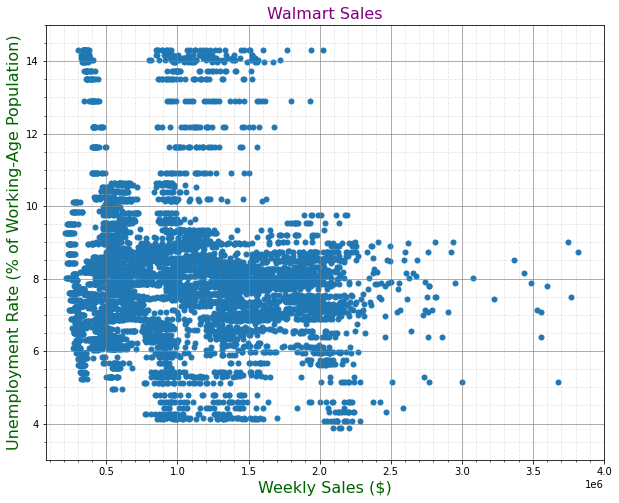

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(75000, 4000000)
ax.set_ylim(3, 15)
ax.scatter(x = walmart_data['Weekly_Sales'], y = walmart_data['Unemployment'],s=25)
ax.set_xlabel('Weekly Sales ($)',fontsize=16,color='Darkgreen')
ax.set_ylabel('Unemployment Rate (% of Working-Age Population)',fontsize=16,color='Darkgreen')
ax.set_title('Walmart Sales',fontsize=16,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()

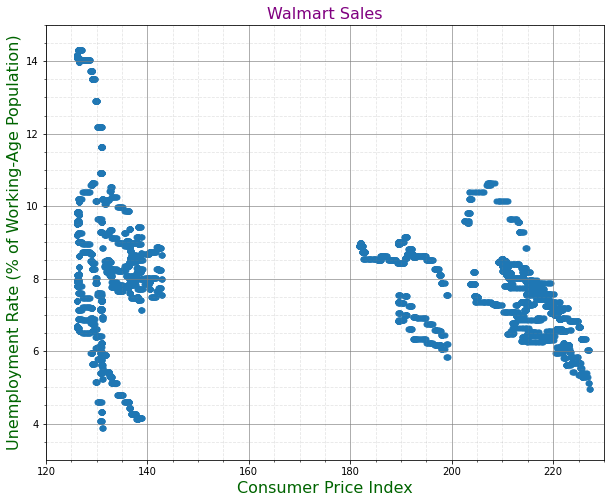

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(120, 230)
ax.set_ylim(3, 15)
ax.scatter(x = walmart_data['CPI'], y = walmart_data['Unemployment'],s=25)
ax.set_xlabel('Consumer Price Index',fontsize=16,color='Darkgreen')
ax.set_ylabel('Unemployment Rate (% of Working-Age Population)',fontsize=16,color='Darkgreen')
ax.set_title('Walmart Sales',fontsize=16,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()

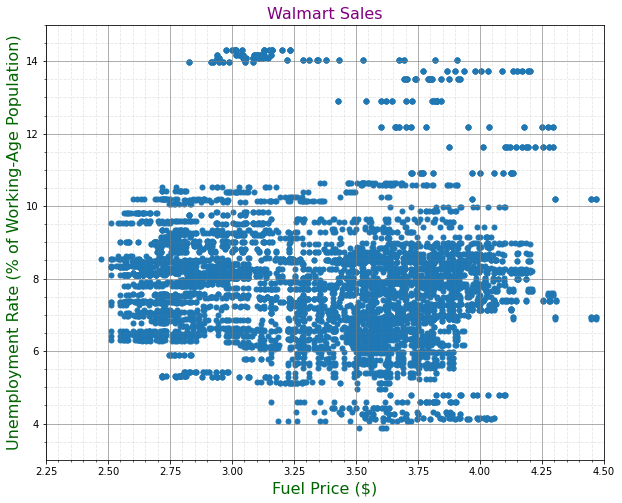

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(2.25, 4.5)
ax.set_ylim(3, 15)
ax.scatter(x = walmart_data['Fuel_Price'], y = walmart_data['Unemployment'],s=25)
ax.set_xlabel('Fuel Price ($)',fontsize=16,color='Darkgreen')
ax.set_ylabel('Unemployment Rate (% of Working-Age Population)',fontsize=16,color='Darkgreen')
ax.set_title('Walmart Sales',fontsize=16,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()

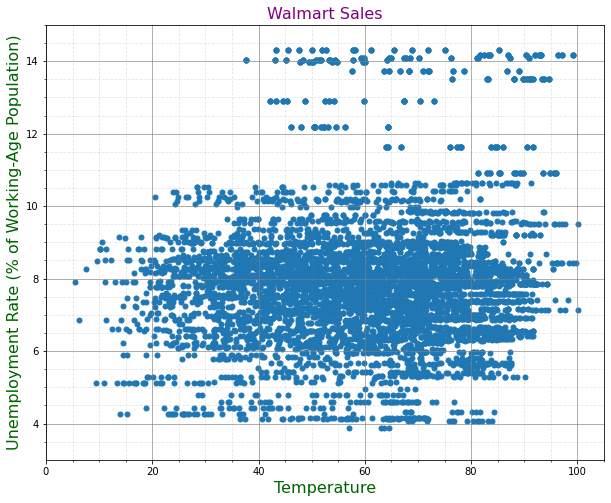

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(0, 105)
ax.set_ylim(3, 15)
ax.scatter(x = walmart_data['Temperature'], y = walmart_data['Unemployment'],s=25)
ax.set_xlabel('Temperature',fontsize=16,color='Darkgreen')
ax.set_ylabel('Unemployment Rate (% of Working-Age Population)',fontsize=16,color='Darkgreen')
ax.set_title('Walmart Sales',fontsize=16,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()

## Best Kernel was Epanechnikov at tau = 0.1 or triweight an tau = 0.1 (will be testing both)

## Testing Kernels, tau = 0.01
Best result was Epanechnikov with an MSE of 1.3360838154798635 and an MAE of 0.7174296028963587; or triangular with an MSE of 1.336083815479864 and an MAE of 0.7174296028963585

In [ ]:
kf = KFold(n_splits=2,shuffle=True,random_state=410) # 10 and even 5 splits took an extremely long time, so I reduced the number of splits (about 7 hours and then Colab disconnected my runtime).
mse_tric_w1 = []
mse_epa_w1 = []
mse_quart_w1 = []
mse_trian_w1 = []
mse_triw_w1 = []
mae_tric_w1 = []
mae_epa_w1 = []
mae_quart_w1 = []
mae_trian_w1 = []
mae_triw_w1 = []

In [ ]:
# Ones without intercepts never did as well, so I got rid of those to increase computing power.
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.01, intercept=True)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.01, intercept=True)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 0.01, intercept=True)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 0.01, intercept=True)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 0.01, intercept=True)

  mse_tric_w1.append(mse(ytest,yhat_tri_T))
  mse_epa_w1.append(mse(ytest,yhat_epa_T))
  mse_quart_w1.append(mse(ytest,yhat_quart_T))
  mse_trian_w1.append(mse(ytest,yhat_trian_T))
  mse_triw_w1.append(mse(ytest,yhat_triw_T))
  mae_tric_w1.append(mae(ytest,yhat_tri_T))
  mae_epa_w1.append(mae(ytest,yhat_epa_T))
  mae_quart_w1.append(mae(ytest,yhat_quart_T))
  mae_trian_w1.append(mae(ytest,yhat_trian_T))
  mae_triw_w1.append(mae(ytest,yhat_triw_T))
  
print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_w1)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_w1)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_w1)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_w1)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_w1)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_w1)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_w1)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_w1)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_w1)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_w1)))

The MSE for LOWESS with the tricubic kernel is: 1.3360838154798638
The MSE for LOWESS with the Epanechnikov kernel is: 1.3360838154798635
The MSE for LOWESS with the quartic kernel is: 1.336083815479864
The MSE for LOWESS with the triangular kernel is: 1.336083815479864
The MSE for LOWESS with the triweight kernel is: 1.336083815479864


The MAE for LOWESS with the tricubic kernel is: 0.7174296028963587
The MAE for LOWESS with the Epanechnikov kernel is: 0.7174296028963587
The MAE for LOWESS with the quartic kernel is: 0.7174296028963587
The MAE for LOWESS with the triangular kernel is: 0.7174296028963585
The MAE for LOWESS with the triweight kernel is: 0.7174296028963586


## Testing Kernels, tau = 0.05
Best result was Epanechnikov with an MSE of 1.3360831 and an MAE of 0.7174283

In [ ]:
kf = KFold(n_splits=2,shuffle=True,random_state=410)
mse_tric_w2 = []
mse_epa_w2 = []
mse_quart_w2 = []
mse_trian_w2 = []
mse_triw_w2 = []
mae_tric_w2 = []
mae_epa_w2 = []
mae_quart_w2 = []
mae_trian_w2 = []
mae_triw_w2 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.05, intercept=True)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.05, intercept=True)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 0.05, intercept=True)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 0.05, intercept=True)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 0.05, intercept=True)

  mse_tric_w2.append(mse(ytest,yhat_tri_T))
  mse_epa_w2.append(mse(ytest,yhat_epa_T))
  mse_quart_w2.append(mse(ytest,yhat_quart_T))
  mse_trian_w2.append(mse(ytest,yhat_trian_T))
  mse_triw_w2.append(mse(ytest,yhat_triw_T))
  mae_tric_w2.append(mae(ytest,yhat_tri_T))
  mae_epa_w2.append(mae(ytest,yhat_epa_T))
  mae_quart_w2.append(mae(ytest,yhat_quart_T))
  mae_trian_w2.append(mae(ytest,yhat_trian_T))
  mae_triw_w2.append(mae(ytest,yhat_triw_T))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_w2)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_w2)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_w2)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_w2)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_w2)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_w2)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_w2)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_w2)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_w2)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_w2)))

The MSE for LOWESS with the tricubic kernel is: 1.3360834437864009
The MSE for LOWESS with the Epanechnikov kernel is: 1.3360831013041237
The MSE for LOWESS with the quartic kernel is: 1.336083415300406
The MSE for LOWESS with the triangular kernel is: 1.3360833113743709
The MSE for LOWESS with the triweight kernel is: 1.3360836385102433


The MAE for LOWESS with the tricubic kernel is: 0.7174289464193448
The MAE for LOWESS with the Epanechnikov kernel is: 0.7174282903065989
The MAE for LOWESS with the quartic kernel is: 0.7174288917274381
The MAE for LOWESS with the triangular kernel is: 0.7174286939095426
The MAE for LOWESS with the triweight kernel is: 0.7174292950282193


## Testing Kernels, tau = 0.1
Best result was Epanechnikov with an MSE of 1.331 and an MAE of 0.7177; or triweight with an MSE of 1.334 and an MAE of 0.71717

In [ ]:
kf = KFold(n_splits=2,shuffle=True,random_state=410)
mse_tric_w3 = []
mse_epa_w3 = []
mse_quart_w3 = []
mse_trian_w3 = []
mse_triw_w3 = []
mae_tric_w3 = []
mae_epa_w3 = []
mae_quart_w3 = []
mae_trian_w3 = []
mae_triw_w3 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.1, intercept=True)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.1, intercept=True)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 0.1, intercept=True)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 0.1, intercept=True)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 0.1, intercept=True)

  mse_tric_w3.append(mse(ytest,yhat_tri_T))
  mse_epa_w3.append(mse(ytest,yhat_epa_T))
  mse_quart_w3.append(mse(ytest,yhat_quart_T))
  mse_trian_w3.append(mse(ytest,yhat_trian_T))
  mse_triw_w3.append(mse(ytest,yhat_triw_T))
  mae_tric_w3.append(mae(ytest,yhat_tri_T))
  mae_epa_w3.append(mae(ytest,yhat_epa_T))
  mae_quart_w3.append(mae(ytest,yhat_quart_T))
  mae_trian_w3.append(mae(ytest,yhat_trian_T))
  mae_triw_w3.append(mae(ytest,yhat_triw_T))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_w3)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_w3)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_w3)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_w3)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_w3)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_w3)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_w3)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_w3)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_w3)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_w3)))

The MSE for LOWESS with the tricubic kernel is: 1.3338319041876967
The MSE for LOWESS with the Epanechnikov kernel is: 1.33311573083214
The MSE for LOWESS with the quartic kernel is: 1.3335212587238696
The MSE for LOWESS with the triangular kernel is: 1.3330859332383185
The MSE for LOWESS with the triweight kernel is: 1.334389459631672


The MAE for LOWESS with the tricubic kernel is: 0.7171936625790933
The MAE for LOWESS with the Epanechnikov kernel is: 0.7176557460117592
The MAE for LOWESS with the quartic kernel is: 0.7172511074152943
The MAE for LOWESS with the triangular kernel is: 0.7174226499547508
The MAE for LOWESS with the triweight kernel is: 0.7171749252108008


## Testing Kernels, tau = 0.5
Best result was triweight with an MSE of 1.63 and an MAE of 0.88

In [ ]:
kf = KFold(n_splits=2,shuffle=True,random_state=410)
mse_tric_w4 = []
mse_epa_w4 = []
mse_quart_w4 = []
mse_trian_w4 = []
mse_triw_w4 = []
mae_tric_w4 = []
mae_epa_w4 = []
mae_quart_w4 = []
mae_trian_w4 = []
mae_triw_w4 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.5, intercept=True)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.5, intercept=True)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 0.5, intercept=True)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 0.5, intercept=True)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 0.5, intercept=True)

  mse_tric_w4.append(mse(ytest,yhat_tri_T))
  mse_epa_w4.append(mse(ytest,yhat_epa_T))
  mse_quart_w4.append(mse(ytest,yhat_quart_T))
  mse_trian_w4.append(mse(ytest,yhat_trian_T))
  mse_triw_w4.append(mse(ytest,yhat_triw_T))
  mae_tric_w4.append(mae(ytest,yhat_tri_T))
  mae_epa_w4.append(mae(ytest,yhat_epa_T))
  mae_quart_w4.append(mae(ytest,yhat_quart_T))
  mae_trian_w4.append(mae(ytest,yhat_trian_T))
  mae_triw_w4.append(mae(ytest,yhat_triw_T))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_w4)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_w4)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_w4)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_w4)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_w4)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_w4)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_w4)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_w4)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_w4)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_w4)))

The MSE for LOWESS with the tricubic kernel is: 1.7058087521396854
The MSE for LOWESS with the Epanechnikov kernel is: 1.8140592827851116
The MSE for LOWESS with the quartic kernel is: 1.7071260683761311
The MSE for LOWESS with the triangular kernel is: 1.754932269593361
The MSE for LOWESS with the triweight kernel is: 1.6287927487786236


The MAE for LOWESS with the tricubic kernel is: 0.9047179439893354
The MAE for LOWESS with the Epanechnikov kernel is: 0.943076794435225
The MAE for LOWESS with the quartic kernel is: 0.9063825843936548
The MAE for LOWESS with the triangular kernel is: 0.9242269829382812
The MAE for LOWESS with the triweight kernel is: 0.8785705199753016


## Testing Kernels, tau = 1
Best result was triweight with an MSE of 2.16 and an MAE of 1.02

In [ ]:
kf = KFold(n_splits=2,shuffle=True,random_state=410)
mse_tric_w5 = []
mse_epa_w5 = []
mse_quart_w5 = []
mse_trian_w5 = []
mse_triw_w5 = []
mae_tric_w5 = []
mae_epa_w5 = []
mae_quart_w5 = []
mae_trian_w5 = []
mae_triw_w5 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 1, intercept=True)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 1, intercept=True)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 1, intercept=True)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 1, intercept=True)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 1, intercept=True)

  mse_tric_w5.append(mse(ytest,yhat_tri_T))
  mse_epa_w5.append(mse(ytest,yhat_epa_T))
  mse_quart_w5.append(mse(ytest,yhat_quart_T))
  mse_trian_w5.append(mse(ytest,yhat_trian_T))
  mse_triw_w5.append(mse(ytest,yhat_triw_T))
  mae_tric_w5.append(mae(ytest,yhat_tri_T))
  mae_epa_w5.append(mae(ytest,yhat_epa_T))
  mae_quart_w5.append(mae(ytest,yhat_quart_T))
  mae_trian_w5.append(mae(ytest,yhat_trian_T))
  mae_triw_w5.append(mae(ytest,yhat_triw_T))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_w5)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_w5)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_w5)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_w5)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_w5)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_w5)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_w5)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_w5)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_w5)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_w5)))

The MSE for LOWESS with the tricubic kernel is: 2.26554790174528
The MSE for LOWESS with the Epanechnikov kernel is: 2.4413179636830673
The MSE for LOWESS with the quartic kernel is: 2.2892512429032283
The MSE for LOWESS with the triangular kernel is: 2.378720731803489
The MSE for LOWESS with the triweight kernel is: 2.159094873158484


The MAE for LOWESS with the tricubic kernel is: 1.045222584528474
The MAE for LOWESS with the Epanechnikov kernel is: 1.0766181154915446
The MAE for LOWESS with the quartic kernel is: 1.0475591482039435
The MAE for LOWESS with the triangular kernel is: 1.0625660605229568
The MAE for LOWESS with the triweight kernel is: 1.0219906941377617


## Testing XGB
Best result was 100 trees, depth of 5, and a lambda of 50 with an MSE of 1.139079

In [ ]:
kf = KFold(n_splits=2,shuffle=True,random_state=410)
mse_100 = []
mse_1000 = []
mse_100_l10 = []
mse_1000_l10 = []
mse_100_l50 = []
mse_1000_l50 = []
mse_100_d5 = []
mse_1000_d5 = []
mse_100_l10_d5 = []
mse_1000_l10_d5 = []
mse_100_l50_d5 = []
mse_1000_l50_d5 = []
mse_100_a5 = []
mse_1000_a5 = []
mse_100_l10_a5 = []
mse_1000_l10_a5 = []
mse_100_l50_a5 = []
mse_1000_l50_a5 = []
mse_100_d5_a5 = []
mse_1000_d5_a5 = []
mse_100_l10_d5_a5 = []
mse_1000_l10_d5_a5 = []
mse_100_l50_d5_a5 = []
mse_1000_l50_d5_a5 = []

In [ ]:
# Alphas didn't seem to make a difference so I removed those (similar to my reasoning for getting rid of taus over 1).  I also wanted to reduce the computing time required,
# similar to my reasoning for reducing the number of loop repetitions in the boosted testing blocks below and the number of k-fold cross validation splits to 2.
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  model_xgb_1 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=20,alpha=1,gamma=10,max_depth=3)
  model_xgb_1.fit(xtrain,ytrain)
  yhat_xgb_1 = model_xgb_1.predict(xtest)

  model_xgb_2 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=20,alpha=1,gamma=10,max_depth=3)
  model_xgb_2.fit(xtrain,ytrain)
  yhat_xgb_2 = model_xgb_2.predict(xtest)

  model_xgb_3 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=10,alpha=1,gamma=10,max_depth=3)
  model_xgb_3.fit(xtrain,ytrain)
  yhat_xgb_3 = model_xgb_3.predict(xtest)

  model_xgb_4 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=10,alpha=1,gamma=10,max_depth=3)
  model_xgb_4.fit(xtrain,ytrain)
  yhat_xgb_4 = model_xgb_4.predict(xtest)

  model_xgb_5 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=50,alpha=1,gamma=10,max_depth=3)
  model_xgb_5.fit(xtrain,ytrain)
  yhat_xgb_5 = model_xgb_5.predict(xtest)

  model_xgb_6 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=50,alpha=1,gamma=10,max_depth=3)
  model_xgb_6.fit(xtrain,ytrain)
  yhat_xgb_6 = model_xgb_6.predict(xtest)

  model_xgb_7 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=20,alpha=1,gamma=10,max_depth=5)
  model_xgb_7.fit(xtrain,ytrain)
  yhat_xgb_7 = model_xgb_7.predict(xtest)

  model_xgb_8 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=20,alpha=1,gamma=10,max_depth=5)
  model_xgb_8.fit(xtrain,ytrain)
  yhat_xgb_8 = model_xgb_8.predict(xtest)

  model_xgb_9 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=10,alpha=1,gamma=10,max_depth=5)
  model_xgb_9.fit(xtrain,ytrain)
  yhat_xgb_9 = model_xgb_9.predict(xtest)

  model_xgb_10 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=10,alpha=1,gamma=10,max_depth=5)
  model_xgb_10.fit(xtrain,ytrain)
  yhat_xgb_10 = model_xgb_10.predict(xtest)

  model_xgb_11 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=50,alpha=1,gamma=10,max_depth=5)
  model_xgb_11.fit(xtrain,ytrain)
  yhat_xgb_11 = model_xgb_11.predict(xtest)

  model_xgb_12 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=50,alpha=1,gamma=10,max_depth=5)
  model_xgb_12.fit(xtrain,ytrain)
  yhat_xgb_12 = model_xgb_12.predict(xtest)

  mse_100.append(mse(ytest,yhat_xgb_1))
  mse_1000.append(mse(ytest,yhat_xgb_2))

  mse_100_l10.append(mse(ytest,yhat_xgb_3))
  mse_1000_l10.append(mse(ytest,yhat_xgb_4))

  mse_100_l50.append(mse(ytest,yhat_xgb_5))
  mse_1000_l50.append(mse(ytest,yhat_xgb_6))

  mse_100_d5.append(mse(ytest,yhat_xgb_7))
  mse_1000_d5.append(mse(ytest,yhat_xgb_8))

  mse_100_l10_d5.append(mse(ytest,yhat_xgb_9))
  mse_1000_l10_d5.append(mse(ytest,yhat_xgb_10))

  mse_100_l50_d5.append(mse(ytest,yhat_xgb_11))
  mse_1000_l50_d5.append(mse(ytest,yhat_xgb_12))

print("The MSE for 100 trees is: " + str(np.mean(mse_100)))
print("The MSE for 1000 trees is: " + str(np.mean(mse_1000)))

print("The MSE for 100 trees and a lambda of 10 is: " + str(np.mean(mse_100_l10)))
print("The MSE for 1000 trees and a lambda of 10 is: " + str(np.mean(mse_1000_l10)))

print("The MSE for 100 trees and a lambda of 50 is: " + str(np.mean(mse_100_l50)))
print("The MSE for 1000 trees and a lambda of 50 is: " + str(np.mean(mse_1000_l50)))

print("The MSE for 100 trees and a depth of 5 is: " + str(np.mean(mse_100_d5)))
print("The MSE for 1000 trees and a depth of 5 is: " + str(np.mean(mse_1000_d5)))

print("The MSE for 100 trees, depth of 5, and a lambda of 10 is: " + str(np.mean(mse_100_l10_d5)))
print("The MSE for 1000 trees, depth of 5, and a lambda of 10 is: " + str(np.mean(mse_1000_l10_d5)))

print("The MSE for 100 trees, depth of 5, and a lambda of 50 is: " + str(np.mean(mse_100_l50_d5)))
print("The MSE for 1000 trees, depth of 5, and a lambda of 50 is: " + str(np.mean(mse_1000_l50_d5)))

The MSE for 100 trees is: 1.4197527129220076
The MSE for 1000 trees is: 1.4197418063166607
The MSE for 100 trees and a lambda of 10 is: 1.4386309428559019
The MSE for 1000 trees and a lambda of 10 is: 1.4386295866626808
The MSE for 100 trees and a lambda of 50 is: 1.4826212352317318
The MSE for 1000 trees and a lambda of 50 is: 1.481631037625375
The MSE for 100 trees and a depth of 5 is: 1.145800388504881
The MSE for 1000 trees and a depth of 5 is: 1.1458006328105226
The MSE for 100 trees, depth of 5, and a lambda of 10 is: 1.1505430261465819
The MSE for 1000 trees, depth of 5, and a lambda of 10 is: 1.1505432784645024
The MSE for 100 trees, depth of 5, and a lambda of 50 is: 1.1390788043432463
The MSE for 1000 trees, depth of 5, and a lambda of 50 is: 1.139082192116716


## Testing boosted
XGB won with an MSE of 1.12 and an MAE of 3.12 (MAE wasn't as good, but the large amount by which the MSE is better than the others is significant enough to make it better)

In [ ]:
mse_lwr_1 = []
mse_lwr_2 = []
mse_blwr_1 = []
mse_blwr_2 = []
mse_xgb = []

mae_lwr_1 = []
mae_lwr_2 = []
mae_blwr_1 = []
mae_blwr_2 = []
mae_xgb = []

for i in range(2): # this loop took over 7 hours with 100, so decreased to 2 random states to loop through
  kf = KFold(n_splits=2,shuffle=True,random_state=i) # this loop took over 7 hours with 10, so decreased to 2 to split
  for idxtrain, idxtest in kf.split(X):
    xtrain = X[idxtrain]
    ytrain = y[idxtrain]
    ytest = y[idxtest]
    xtest = X[idxtest]

    xtrain = scale.fit_transform(xtrain)
    xtest = scale.transform(xtest)

    yhat_lwr_1 = lw_reg(xtrain,ytrain, xtest,Epanechnikov,tau=0.1,intercept=True)
    yhat_lwr_2 = lw_reg(xtrain,ytrain, xtest,Triweight,tau=0.1,intercept=True)
    yhat_blwr_1 = boosted_lwr(xtrain,ytrain, xtest,Epanechnikov,tau=0.1,intercept=True)
    yhat_blwr_2 = boosted_lwr(xtrain,ytrain, xtest,Triweight,tau=0.1,intercept=True)
    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=50,alpha=1,gamma=10,max_depth=5)
    model_xgb.fit(xtrain,ytrain)
    yhat_xgb = model_xgb.predict(xtest)

    mse_lwr_1.append(mse(ytest,yhat_lwr_1))
    mse_lwr_2.append(mse(ytest,yhat_lwr_2))
    mse_blwr_1.append(mse(ytest,yhat_blwr_1))
    mse_blwr_2.append(mse(ytest,yhat_blwr_2))
    mse_xgb.append(mse(ytest, yhat_xgb))

    mae_lwr_1.append(mae(ytest,yhat_lwr_1))
    mae_lwr_2.append(mae(ytest,yhat_lwr_2))
    mae_blwr_1.append(mae(ytest,yhat_blwr_1))
    mae_blwr_2.append(mae(ytest,yhat_blwr_2))
    mae_xgb.append(mae(ytest, yhat_xgb))
print('The Cross-validated Mean Squared Error for Epanechnikov LWR is : ' + str(np.mean(mse_lwr_1)))
print('The Cross-validated Mean Squared Error for triweight LWR is : ' + str(np.mean(mse_lwr_2)))
print('The Cross-validated Mean Squared Error for Epanechnikov BLWR is : '+str(np.mean(mse_blwr_1)))
print('The Cross-validated Mean Squared Error for triweight BLWR is : '+str(np.mean(mse_blwr_2)))
print('The Cross-validated Mean Squared Error for XGB is : '+str(np.mean(mse_xgb)))

print('The Cross-validated Mean Absolute Error for Epanechnikov LWR is : ' + str(np.mean(mae_lwr_1)))
print('The Cross-validated Mean Absolute Error for triweight LWR is : ' + str(np.mean(mae_lwr_2)))
print('The Cross-validated Mean Absolute Error for Epanechnikov BLWR is : '+str(np.mean(mae_blwr_1)))
print('The Cross-validated Mean Absolute Error for triweight BLWR is : '+str(np.mean(mae_blwr_2)))
print('The Cross-validated Mean Absolute Error for XGB is : '+str(np.mean(mae_xgb)))

The Cross-validated Mean Squared Error for Epanechnikov LWR is : 1.3829405354864757
The Cross-validated Mean Squared Error for triweight LWR is : 1.3848264019763212
The Cross-validated Mean Squared Error for Epanechnikov BLWR is : 1.3827644371258716
The Cross-validated Mean Squared Error for triweight BLWR is : 1.3845036068347598
The Cross-validated Mean Squared Error for XGB is : 1.1183568955786183
The Cross-validated Mean Absolute Error for Epanechnikov LWR is : 0.7205493307590602
The Cross-validated Mean Absolute Error for triweight LWR is : 0.7201070071739819
The Cross-validated Mean Absolute Error for Epanechnikov BLWR is : 0.7206751666809511
The Cross-validated Mean Absolute Error for triweight BLWR is : 0.7201553980530904
The Cross-validated Mean Absolute Error for XGB is : 0.767931948469544


## Concrete Strength Data

In [ ]:
concrete = pd.read_excel("Concrete_Data.xls")

In [ ]:
X = concrete[['Coarse Aggregate  (component 6)(kg in a m^3 mixture)', 'Water  (component 4)(kg in a m^3 mixture)', 'Age (day)']].values
y = concrete["Concrete compressive strength(MPa, megapascals) "].values

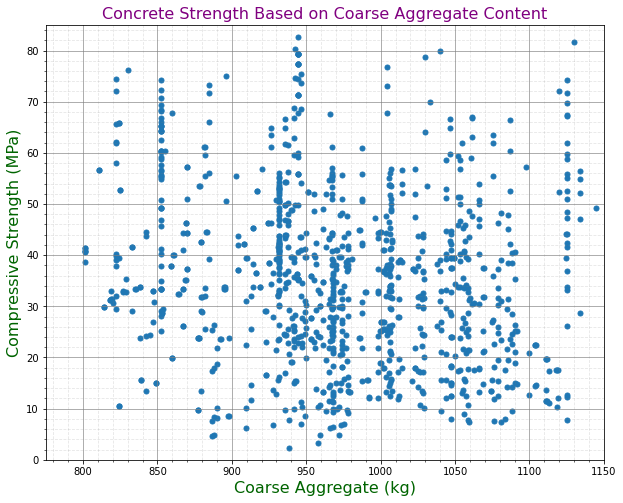

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(775, 1150)
ax.set_ylim(0, 85)
ax.scatter(x = concrete['Coarse Aggregate  (component 6)(kg in a m^3 mixture)'], y = concrete['Concrete compressive strength(MPa, megapascals) '],s=25)
ax.set_xlabel('Coarse Aggregate (kg)',fontsize=16,color='Darkgreen')
ax.set_ylabel('Compressive Strength (MPa)',fontsize=16,color='Darkgreen')
ax.set_title('Concrete Strength Based on Coarse Aggregate Content',fontsize=16,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()

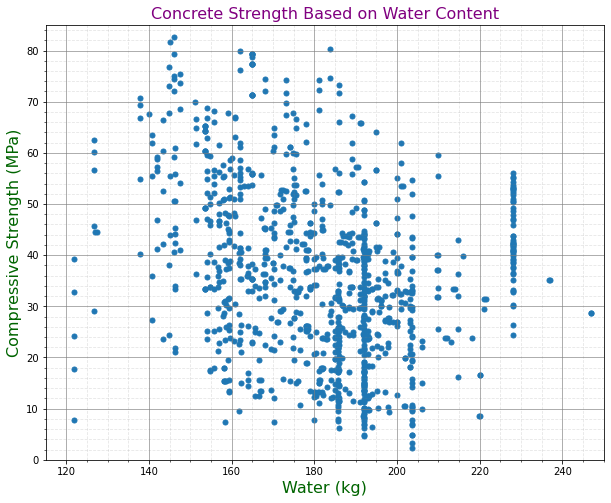

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(115, 250)
ax.set_ylim(0, 85)
ax.scatter(x = concrete['Water  (component 4)(kg in a m^3 mixture)'], y = concrete['Concrete compressive strength(MPa, megapascals) '],s=25)
ax.set_xlabel('Water (kg)',fontsize=16,color='Darkgreen')
ax.set_ylabel('Compressive Strength (MPa)',fontsize=16,color='Darkgreen')
ax.set_title('Concrete Strength Based on Water Content',fontsize=16,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()

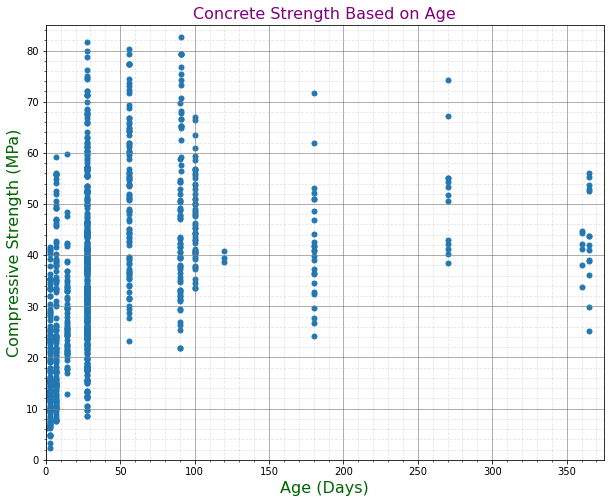

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(0, 375)
ax.set_ylim(0, 85)
ax.scatter(x = concrete['Age (day)'], y = concrete['Concrete compressive strength(MPa, megapascals) '],s=25)
ax.set_xlabel('Age (Days)',fontsize=16,color='Darkgreen')
ax.set_ylabel('Compressive Strength (MPa)',fontsize=16,color='Darkgreen')
ax.set_title('Concrete Strength Based on Age',fontsize=16,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()

## Best Kernel result was Epanechnikov at a tau of 0.05, or triangular at a tau of 0.05 (will be testing both)

## Testing Kernels, tau = 0.01
Best result was Triangular with an MSE of 78.96070 and an MAE of 5.9042998; or Tricubic with an MSE of 78.9613 and an MAE of 5.90424.

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_con1 = []
mse_epa_con1 = []
mse_quart_con1 = []
mse_trian_con1 = []
mse_triw_con1 = []
mae_tric_con1 = []
mae_epa_con1 = []
mae_quart_con1 = []
mae_trian_con1 = []
mae_triw_con1 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.01, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.01, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.01, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.01, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 0.01, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 0.01, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 0.01, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 0.01, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 0.01, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 0.01, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_con1.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_con1.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_con1.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_con1.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_con1.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_con1.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_con1.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_con1.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_con1.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_con1.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_con1.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_con1.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_con1.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_con1.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_con1.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_con1.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_con1.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_con1.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_con1.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_con1.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_con1)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_con1)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_con1)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_con1)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_con1)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_con1)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_con1)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_con1)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_con1)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_con1)))

The MSE for LOWESS with the tricubic kernel is: 78.9612951355106
The MSE for LOWESS with the Epanechnikov kernel is: 78.96106560320327
The MSE for LOWESS with the quartic kernel is: 78.96109621790018
The MSE for LOWESS with the triangular kernel is: 78.96070007145488
The MSE for LOWESS with the triweight kernel is: 78.96107618980895


The MAE for LOWESS with the tricubic kernel is: 5.904242693965007
The MAE for LOWESS with the Epanechnikov kernel is: 5.904333736514415
The MAE for LOWESS with the quartic kernel is: 5.904288515284444
The MAE for LOWESS with the triangular kernel is: 5.904299753424924
The MAE for LOWESS with the triweight kernel is: 5.904310418895762


## Testing Kernels, tau = 0.05
Best result was Epanechnikov with an MSE of 78.20 and an MAE of 5.897; or triangular with an MSE of 78.33 and an MAE of 5.894.

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_con2 = []
mse_epa_con2 = []
mse_quart_con2 = []
mse_trian_con2 = []
mse_triw_con2 = []
mae_tric_con2 = []
mae_epa_con2 = []
mae_quart_con2 = []
mae_trian_con2 = []
mae_triw_con2 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.05, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.05, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.05, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.05, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 0.05, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 0.05, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 0.05, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 0.05, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 0.05, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 0.05, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_con2.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_con2.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_con2.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_con2.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_con2.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_con2.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_con2.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_con2.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_con2.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_con2.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_con2.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_con2.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_con2.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_con2.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_con2.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_con2.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_con2.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_con2.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_con2.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_con2.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_con2)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_con2)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_con2)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_con2)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_con2)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_con2)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_con2)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_con2)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_con2)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_con2)))

The MSE for LOWESS with the tricubic kernel is: 78.60949688317064
The MSE for LOWESS with the Epanechnikov kernel is: 78.2014963800327
The MSE for LOWESS with the quartic kernel is: 78.54494381465295
The MSE for LOWESS with the triangular kernel is: 78.33156472274177
The MSE for LOWESS with the triweight kernel is: 78.72792163141949


The MAE for LOWESS with the tricubic kernel is: 5.895917459897308
The MAE for LOWESS with the Epanechnikov kernel is: 5.897363524891021
The MAE for LOWESS with the quartic kernel is: 5.895153621906753
The MAE for LOWESS with the triangular kernel is: 5.893888982412172
The MAE for LOWESS with the triweight kernel is: 5.898968009753649


## Testing Kernels, tau = 0.1
Best result was triweight with an MSE of 78.05 and an MAE of 5.98



In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_con3 = []
mse_epa_con3 = []
mse_quart_con3 = []
mse_trian_con3 = []
mse_triw_con3 = []
mae_tric_con3 = []
mae_epa_con3 = []
mae_quart_con3 = []
mae_trian_con3 = []
mae_triw_con3 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.1, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.1, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.1, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.1, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 0.1, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 0.1, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 0.1, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 0.1, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 0.1, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 0.1, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_con3.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_con3.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_con3.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_con3.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_con3.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_con3.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_con3.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_con3.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_con3.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_con3.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_con3.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_con3.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_con3.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_con3.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_con3.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_con3.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_con3.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_con3.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_con3.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_con3.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_con3)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_con3)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_con3)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_con3)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_con3)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_con3)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_con3)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_con3)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_con3)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_con3)))

The MSE for LOWESS with the tricubic kernel is: 78.51033690804931
The MSE for LOWESS with the Epanechnikov kernel is: 79.15004837869625
The MSE for LOWESS with the quartic kernel is: 78.43465083312151
The MSE for LOWESS with the triangular kernel is: 78.38190103734958
The MSE for LOWESS with the triweight kernel is: 78.0533793586676


The MAE for LOWESS with the tricubic kernel is: 6.028928952567277
The MAE for LOWESS with the Epanechnikov kernel is: 6.107941812851543
The MAE for LOWESS with the quartic kernel is: 6.029879442436413
The MAE for LOWESS with the triangular kernel is: 6.045765138940844
The MAE for LOWESS with the triweight kernel is: 5.977576803982639


## Testing Kernels, tau = 0.5
Best result was triweight with an MSE of 103.32 and an MAE of 7.59

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_con4 = []
mse_epa_con4 = []
mse_quart_con4 = []
mse_trian_con4 = []
mse_triw_con4 = []
mae_tric_con4 = []
mae_epa_con4 = []
mae_quart_con4 = []
mae_trian_con4 = []
mae_triw_con4 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.5, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 0.5, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.5, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 0.5, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 0.5, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 0.5, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 0.5, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 0.5, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 0.5, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 0.5, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_con4.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_con4.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_con4.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_con4.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_con4.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_con4.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_con4.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_con4.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_con4.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_con4.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_con4.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_con4.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_con4.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_con4.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_con4.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_con4.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_con4.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_con4.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_con4.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_con4.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_con4)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_con4)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_con4)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_con4)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_con4)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_con4)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_con4)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_con4)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_con4)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_con4)))

The MSE for LOWESS with the tricubic kernel is: 107.51434119825285
The MSE for LOWESS with the Epanechnikov kernel is: 111.95328109137215
The MSE for LOWESS with the quartic kernel is: 106.86945713327123
The MSE for LOWESS with the triangular kernel is: 108.0715800840873
The MSE for LOWESS with the triweight kernel is: 103.32117104787874


The MAE for LOWESS with the tricubic kernel is: 7.801750566178408
The MAE for LOWESS with the Epanechnikov kernel is: 8.041330952286406
The MAE for LOWESS with the quartic kernel is: 7.783461418543892
The MAE for LOWESS with the triangular kernel is: 7.862938557263627
The MAE for LOWESS with the triweight kernel is: 7.593979604100911


## Testing Kernels, tau = 1
Best result was triweight with an MSE of 121.62 and an MAE of 8.48

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_con5 = []
mse_epa_con5 = []
mse_quart_con5 = []
mse_trian_con5 = []
mse_triw_con5 = []
mae_tric_con5 = []
mae_epa_con5 = []
mae_quart_con5 = []
mae_trian_con5 = []
mae_triw_con5 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 1, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 1, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 1, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 1, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 1, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 1, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 1, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 1, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 1, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 1, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_con5.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_con5.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_con5.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_con5.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_con5.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_con5.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_con5.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_con5.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_con5.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_con5.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_con5.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_con5.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_con5.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_con5.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_con5.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_con5.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_con5.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_con5.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_con5.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_con5.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_con5)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_con5)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_con5)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_con5)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_con5)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_con5)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_con5)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_con5)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_con5)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_con5)))

The MSE for LOWESS with the tricubic kernel is: 125.53490280562082
The MSE for LOWESS with the Epanechnikov kernel is: 129.14193070505908
The MSE for LOWESS with the quartic kernel is: 124.95893388604289
The MSE for LOWESS with the triangular kernel is: 125.9445170058594
The MSE for LOWESS with the triweight kernel is: 121.62274684832134


The MAE for LOWESS with the tricubic kernel is: 8.661283463042313
The MAE for LOWESS with the Epanechnikov kernel is: 8.833985868294471
The MAE for LOWESS with the quartic kernel is: 8.63886055417272
The MAE for LOWESS with the triangular kernel is: 8.689888781885825
The MAE for LOWESS with the triweight kernel is: 8.482802591316222


## Testing Kernels, tau = 1.25
Best result was triweight with an MSE of 126.68 and an MAE of 8.72

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_con6 = []
mse_epa_con6 = []
mse_quart_con6 = []
mse_trian_con6 = []
mse_triw_con6 = []
mae_tric_con6 = []
mae_epa_con6 = []
mae_quart_con6 = []
mae_trian_con6 = []
mae_triw_con6 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 1.25, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 1.25, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 1.25, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 1.25, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 1.25, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 1.25, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 1.25, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 1.25, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 1.25, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 1.25, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_con6.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_con6.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_con6.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_con6.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_con6.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_con6.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_con6.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_con6.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_con6.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_con6.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_con6.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_con6.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_con6.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_con6.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_con6.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_con6.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_con6.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_con6.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_con6.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_con6.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_con6)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_con6)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_con6)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_con6)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_con6)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_con6)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_con6)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_con6)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_con6)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_con6)))

The MSE for LOWESS with the tricubic kernel is: 130.2224558955878
The MSE for LOWESS with the Epanechnikov kernel is: 133.65843238938612
The MSE for LOWESS with the quartic kernel is: 129.5455626818833
The MSE for LOWESS with the triangular kernel is: 130.43994676007065
The MSE for LOWESS with the triweight kernel is: 126.68138486218368


The MAE for LOWESS with the tricubic kernel is: 8.888377970678123
The MAE for LOWESS with the Epanechnikov kernel is: 9.054837861705536
The MAE for LOWESS with the quartic kernel is: 8.859952953181413
The MAE for LOWESS with the triangular kernel is: 8.911951652032506
The MAE for LOWESS with the triweight kernel is: 8.718676784021493


## Testing Kernels, tau = 1.5
Best result was triweight with an MSE of 130.89 and an MAE of 8.93

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_con7 = []
mse_epa_con7 = []
mse_quart_con7 = []
mse_trian_con7 = []
mse_triw_con7 = []
mae_tric_con7 = []
mae_epa_con7 = []
mae_quart_con7 = []
mae_trian_con7 = []
mae_triw_con7 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 1.5, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 1.5, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 1.5, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 1.5, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 1.5, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 1.5, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 1.5, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 1.5, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 1.5, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 1.5, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_con7.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_con7.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_con7.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_con7.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_con7.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_con7.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_con7.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_con7.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_con7.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_con7.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_con7.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_con7.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_con7.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_con7.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_con7.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_con7.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_con7.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_con7.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_con7.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_con7.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_con7)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_con7)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_con7)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_con7)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_con7)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_con7)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_con7)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_con7)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_con7)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_con7)))

The MSE for LOWESS with the tricubic kernel is: 134.7076045476455
The MSE for LOWESS with the Epanechnikov kernel is: 139.4196559155373
The MSE for LOWESS with the quartic kernel is: 134.35133521579505
The MSE for LOWESS with the triangular kernel is: 135.9505694858039
The MSE for LOWESS with the triweight kernel is: 130.893530283943


The MAE for LOWESS with the tricubic kernel is: 9.096247815127892
The MAE for LOWESS with the Epanechnikov kernel is: 9.264178898164069
The MAE for LOWESS with the quartic kernel is: 9.07720635384571
The MAE for LOWESS with the triangular kernel is: 9.132542984323305
The MAE for LOWESS with the triweight kernel is: 8.927863311180017


## Testing Kernels, tau = 2
Best result was triweight with an MSE of 139.15 and an MAE of 9.26

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_tric_con8 = []
mse_epa_con8 = []
mse_quart_con8 = []
mse_trian_con8 = []
mse_triw_con8 = []
mae_tric_con8 = []
mae_epa_con8 = []
mae_quart_con8 = []
mae_trian_con8 = []
mae_triw_con8 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  yhat_tri_T = lw_reg(xtrain, ytrain, xtest, Tricubic, 2, intercept=True)
  yhat_tri_F = lw_reg(xtrain, ytrain, xtest, Tricubic, 2, intercept=False)
  yhat_epa_T = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 2, intercept=True)
  yhat_epa_F = lw_reg(xtrain, ytrain, xtest, Epanechnikov, 2, intercept=False)
  yhat_quart_T = lw_reg(xtrain, ytrain, xtest, Quartic, 2, intercept=True)
  yhat_quart_F = lw_reg(xtrain, ytrain, xtest, Quartic, 2, intercept=False)
  yhat_trian_T = lw_reg(xtrain, ytrain, xtest, Triangular, 2, intercept=True)
  yhat_trian_F = lw_reg(xtrain, ytrain, xtest, Triangular, 2, intercept=False)
  yhat_triw_T = lw_reg(xtrain, ytrain, xtest, Triweight, 2, intercept=True)
  yhat_triw_F = lw_reg(xtrain, ytrain, xtest, Triweight, 2, intercept=False)

  if(mse(ytest,yhat_tri_T) < mse(ytest,yhat_tri_F)):
    mse_tric_con8.append(mse(ytest,yhat_tri_T))
  else:
    mse_tric_con8.append(mse(ytest,yhat_tri_F))

  if(mse(ytest,yhat_epa_T) < mse(ytest,yhat_epa_F)):
    mse_epa_con8.append(mse(ytest,yhat_epa_T))
  else:
    mse_epa_con8.append(mse(ytest,yhat_epa_F))

  if(mse(ytest,yhat_quart_T) < mse(ytest,yhat_quart_F)):
    mse_quart_con8.append(mse(ytest,yhat_quart_T))
  else:
    mse_quart_con8.append(mse(ytest,yhat_quart_F))

  if(mse(ytest,yhat_trian_T) < mse(ytest,yhat_trian_F)):
    mse_trian_con8.append(mse(ytest,yhat_trian_T))
  else:
    mse_trian_con8.append(mse(ytest,yhat_trian_F))
  
  if(mse(ytest,yhat_triw_T) < mse(ytest,yhat_triw_F)):
    mse_triw_con8.append(mse(ytest,yhat_triw_T))
  else:
    mse_triw_con8.append(mse(ytest,yhat_triw_F))


  if(mae(ytest,yhat_tri_T) < mae(ytest,yhat_tri_F)):
    mae_tric_con8.append(mae(ytest,yhat_tri_T))
  else:
    mae_tric_con8.append(mae(ytest,yhat_tri_F))

  if(mae(ytest,yhat_epa_T) < mae(ytest,yhat_epa_F)):
    mae_epa_con8.append(mae(ytest,yhat_epa_T))
  else:
    mae_epa_con8.append(mae(ytest,yhat_epa_F))

  if(mae(ytest,yhat_quart_T) < mae(ytest,yhat_quart_F)):
    mae_quart_con8.append(mae(ytest,yhat_quart_T))
  else:
    mae_quart_con8.append(mae(ytest,yhat_quart_F))

  if(mae(ytest,yhat_trian_T) < mae(ytest,yhat_trian_F)):
    mae_trian_con8.append(mae(ytest,yhat_trian_T))
  else:
    mae_trian_con8.append(mae(ytest,yhat_trian_F))
  
  if(mae(ytest,yhat_triw_T) < mae(ytest,yhat_triw_F)):
    mae_triw_con8.append(mae(ytest,yhat_triw_T))
  else:
    mae_triw_con8.append(mae(ytest,yhat_triw_F))

print("The MSE for LOWESS with the tricubic kernel is: " + str(np.mean(mse_tric_con8)))
print("The MSE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mse_epa_con8)))
print("The MSE for LOWESS with the quartic kernel is: " + str(np.mean(mse_quart_con8)))
print("The MSE for LOWESS with the triangular kernel is: " + str(np.mean(mse_trian_con8)))
print("The MSE for LOWESS with the triweight kernel is: " + str(np.mean(mse_triw_con8)))
print("\n")
print("The MAE for LOWESS with the tricubic kernel is: " + str(np.mean(mae_tric_con8)))
print("The MAE for LOWESS with the Epanechnikov kernel is: " + str(np.mean(mae_epa_con8)))
print("The MAE for LOWESS with the quartic kernel is: " + str(np.mean(mae_quart_con8)))
print("The MAE for LOWESS with the triangular kernel is: " + str(np.mean(mae_trian_con8)))
print("The MAE for LOWESS with the triweight kernel is: " + str(np.mean(mae_triw_con8)))

The MSE for LOWESS with the tricubic kernel is: 143.27675113193152
The MSE for LOWESS with the Epanechnikov kernel is: 147.68438227940075
The MSE for LOWESS with the quartic kernel is: 142.7458403792453
The MSE for LOWESS with the triangular kernel is: 144.11129494144
The MSE for LOWESS with the triweight kernel is: 139.15140691580328


The MAE for LOWESS with the tricubic kernel is: 9.400878172577839
The MAE for LOWESS with the Epanechnikov kernel is: 9.550127182980503
The MAE for LOWESS with the quartic kernel is: 9.380320869034055
The MAE for LOWESS with the triangular kernel is: 9.423873545698587
The MAE for LOWESS with the triweight kernel is: 9.25547700876778


## Testing XGB
Best result was 1000 trees, depth of 5, and a lambda of 10; or 1000 trees, depth of 5, lambda of 10, and an alpha of 5; with an MSE of 48.45 (will be testing both)

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state=410)
mse_100 = []
mse_1000 = []
mse_100_l10 = []
mse_1000_l10 = []
mse_100_l50 = []
mse_1000_l50 = []
mse_100_d5 = []
mse_1000_d5 = []
mse_100_l10_d5 = []
mse_1000_l10_d5 = []
mse_100_l50_d5 = []
mse_1000_l50_d5 = []
mse_100_a5 = []
mse_1000_a5 = []
mse_100_l10_a5 = []
mse_1000_l10_a5 = []
mse_100_l50_a5 = []
mse_1000_l50_a5 = []
mse_100_d5_a5 = []
mse_1000_d5_a5 = []
mse_100_l10_d5_a5 = []
mse_1000_l10_d5_a5 = []
mse_100_l50_d5_a5 = []
mse_1000_l50_d5_a5 = []

In [ ]:
for idxtrain, idxtest in kf.split(X):
  ytrain = y[idxtrain]
  xtrain = X[idxtrain]
  ytest = y[idxtest]
  xtest = X[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  model_xgb_1 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=20,alpha=1,gamma=10,max_depth=3)
  model_xgb_1.fit(xtrain,ytrain)
  yhat_xgb_1 = model_xgb_1.predict(xtest)

  model_xgb_2 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=20,alpha=1,gamma=10,max_depth=3)
  model_xgb_2.fit(xtrain,ytrain)
  yhat_xgb_2 = model_xgb_2.predict(xtest)

  model_xgb_3 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=10,alpha=1,gamma=10,max_depth=3)
  model_xgb_3.fit(xtrain,ytrain)
  yhat_xgb_3 = model_xgb_3.predict(xtest)

  model_xgb_4 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=10,alpha=1,gamma=10,max_depth=3)
  model_xgb_4.fit(xtrain,ytrain)
  yhat_xgb_4 = model_xgb_4.predict(xtest)

  model_xgb_5 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=50,alpha=1,gamma=10,max_depth=3)
  model_xgb_5.fit(xtrain,ytrain)
  yhat_xgb_5 = model_xgb_5.predict(xtest)

  model_xgb_6 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=50,alpha=1,gamma=10,max_depth=3)
  model_xgb_6.fit(xtrain,ytrain)
  yhat_xgb_6 = model_xgb_6.predict(xtest)

  model_xgb_7 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=20,alpha=1,gamma=10,max_depth=5)
  model_xgb_7.fit(xtrain,ytrain)
  yhat_xgb_7 = model_xgb_7.predict(xtest)

  model_xgb_8 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=20,alpha=1,gamma=10,max_depth=5)
  model_xgb_8.fit(xtrain,ytrain)
  yhat_xgb_8 = model_xgb_8.predict(xtest)

  model_xgb_9 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=10,alpha=1,gamma=10,max_depth=5)
  model_xgb_9.fit(xtrain,ytrain)
  yhat_xgb_9 = model_xgb_9.predict(xtest)

  model_xgb_10 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=10,alpha=1,gamma=10,max_depth=5)
  model_xgb_10.fit(xtrain,ytrain)
  yhat_xgb_10 = model_xgb_10.predict(xtest)

  model_xgb_11 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=50,alpha=1,gamma=10,max_depth=5)
  model_xgb_11.fit(xtrain,ytrain)
  yhat_xgb_11 = model_xgb_11.predict(xtest)

  model_xgb_12 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=50,alpha=1,gamma=10,max_depth=5)
  model_xgb_12.fit(xtrain,ytrain)
  yhat_xgb_12 = model_xgb_12.predict(xtest)

  model_xgb_13 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=20,alpha=5,gamma=10,max_depth=3)
  model_xgb_13.fit(xtrain,ytrain)
  yhat_xgb_13 = model_xgb_13.predict(xtest)

  model_xgb_14 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=20,alpha=5,gamma=10,max_depth=3)
  model_xgb_14.fit(xtrain,ytrain)
  yhat_xgb_14 = model_xgb_14.predict(xtest)

  model_xgb_15 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=10,alpha=5,gamma=10,max_depth=3)
  model_xgb_15.fit(xtrain,ytrain)
  yhat_xgb_15 = model_xgb_15.predict(xtest)

  model_xgb_16 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=10,alpha=5,gamma=10,max_depth=3)
  model_xgb_16.fit(xtrain,ytrain)
  yhat_xgb_16 = model_xgb_16.predict(xtest)

  model_xgb_17 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=50,alpha=5,gamma=10,max_depth=3)
  model_xgb_17.fit(xtrain,ytrain)
  yhat_xgb_17 = model_xgb_17.predict(xtest)

  model_xgb_18 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=50,alpha=5,gamma=10,max_depth=3)
  model_xgb_18.fit(xtrain,ytrain)
  yhat_xgb_18 = model_xgb_18.predict(xtest)

  model_xgb_19 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=20,alpha=5,gamma=10,max_depth=5)
  model_xgb_19.fit(xtrain,ytrain)
  yhat_xgb_19 = model_xgb_19.predict(xtest)

  model_xgb_20 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=20,alpha=5,gamma=10,max_depth=5)
  model_xgb_20.fit(xtrain,ytrain)
  yhat_xgb_20 = model_xgb_20.predict(xtest)

  model_xgb_21 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=10,alpha=5,gamma=10,max_depth=5)
  model_xgb_21.fit(xtrain,ytrain)
  yhat_xgb_21 = model_xgb_21.predict(xtest)

  model_xgb_22 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=10,alpha=5,gamma=10,max_depth=5)
  model_xgb_22.fit(xtrain,ytrain)
  yhat_xgb_22 = model_xgb_22.predict(xtest)

  model_xgb_23 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=50,alpha=5,gamma=10,max_depth=5)
  model_xgb_23.fit(xtrain,ytrain)
  yhat_xgb_23 = model_xgb_23.predict(xtest)

  model_xgb_24 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=50,alpha=5,gamma=10,max_depth=5)
  model_xgb_24.fit(xtrain,ytrain)
  yhat_xgb_24 = model_xgb_24.predict(xtest)

  mse_100.append(mse(ytest,yhat_xgb_1))
  mse_1000.append(mse(ytest,yhat_xgb_2))

  mse_100_l10.append(mse(ytest,yhat_xgb_3))
  mse_1000_l10.append(mse(ytest,yhat_xgb_4))

  mse_100_l50.append(mse(ytest,yhat_xgb_5))
  mse_1000_l50.append(mse(ytest,yhat_xgb_6))

  mse_100_d5.append(mse(ytest,yhat_xgb_7))
  mse_1000_d5.append(mse(ytest,yhat_xgb_8))

  mse_100_l10_d5.append(mse(ytest,yhat_xgb_9))
  mse_1000_l10_d5.append(mse(ytest,yhat_xgb_10))

  mse_100_l50_d5.append(mse(ytest,yhat_xgb_11))
  mse_1000_l50_d5.append(mse(ytest,yhat_xgb_12))

  mse_100_a5.append(mse(ytest,yhat_xgb_13))
  mse_1000_a5.append(mse(ytest,yhat_xgb_14))

  mse_100_l10_a5.append(mse(ytest,yhat_xgb_15))
  mse_1000_l10_a5.append(mse(ytest,yhat_xgb_16))

  mse_100_l50_a5.append(mse(ytest,yhat_xgb_17))
  mse_1000_l50_a5.append(mse(ytest,yhat_xgb_18))

  mse_100_d5_a5.append(mse(ytest,yhat_xgb_19))
  mse_1000_d5_a5.append(mse(ytest,yhat_xgb_20))

  mse_100_l10_d5_a5.append(mse(ytest,yhat_xgb_21))
  mse_1000_l10_d5_a5.append(mse(ytest,yhat_xgb_22))

  mse_100_l50_d5_a5.append(mse(ytest,yhat_xgb_23))
  mse_1000_l50_d5_a5.append(mse(ytest,yhat_xgb_24))

print("The MSE for 100 trees is: " + str(np.mean(mse_100)))
print("The MSE for 1000 trees is: " + str(np.mean(mse_1000)))

print("The MSE for 100 trees and a lambda of 10 is: " + str(np.mean(mse_100_l10)))
print("The MSE for 1000 trees and a lambda of 10 is: " + str(np.mean(mse_1000_l10)))

print("The MSE for 100 trees and a lambda of 50 is: " + str(np.mean(mse_100_l50)))
print("The MSE for 1000 trees and a lambda of 50 is: " + str(np.mean(mse_1000_l50)))

print("The MSE for 100 trees and a depth of 5 is: " + str(np.mean(mse_100_d5)))
print("The MSE for 1000 trees and a depth of 5 is: " + str(np.mean(mse_1000_d5)))

print("The MSE for 100 trees, depth of 5, and a lambda of 10 is: " + str(np.mean(mse_100_l10_d5)))
print("The MSE for 1000 trees, depth of 5, and a lambda of 10 is: " + str(np.mean(mse_1000_l10_d5)))

print("The MSE for 100 trees, depth of 5, and a lambda of 50 is: " + str(np.mean(mse_100_l50_d5)))
print("The MSE for 1000 trees, depth of 5, and a lambda of 50 is: " + str(np.mean(mse_1000_l50_d5)))

print("The MSE for 100 tres and an alpha of 5 is: " + str(np.mean(mse_100_a5)))
print("The MSE for 1000 trees and an alpha of 5 is: " + str(np.mean(mse_1000_a5)))

print("The MSE for 100 trees, lambda of 10, and an alpha of 5 is: " + str(np.mean(mse_100_l10_a5)))
print("The MSE for 1000 trees, lambda of 10, and an alpha of 5 is: " + str(np.mean(mse_1000_l10_a5)))

print("The MSE for 100 trees, lambda of 50, and an alpha of 5 is: " + str(np.mean(mse_100_l50_a5)))
print("The MSE for 1000 trees, lambda of 50, and an alpha of 5 is: " + str(np.mean(mse_1000_l50_a5)))

print("The MSE for 100 trees, depth of 5, and an alpha of 5 is: " + str(np.mean(mse_100_d5_a5)))
print("The MSE for 1000 trees, depth of 5, and an alpha of 5 is: " + str(np.mean(mse_1000_d5_a5)))

print("The MSE for 100 trees, lambda of 10, depth of 5, and an alpha of 5 is: " + str(np.mean(mse_100_l10_d5_a5)))
print("The MSE for 1000 trees, lambda of 10, depth of 5, and an alpha of 5 is: " + str(np.mean(mse_1000_l10_d5_a5)))

print("The MSE for 100 trees, lambda of 50, depth of 5, and an alpha of 5 is: " + str(np.mean(mse_100_l50_d5_a5)))
print("The MSE for 1000 trees, lambda of 50, depth of 5, and an alpha of 5 is: " + str(np.mean(mse_1000_l50_d5_a5)))

The MSE for 100 trees is: 79.22848688595481
The MSE for 1000 trees is: 55.07871015831273
The MSE for 100 trees and a lambda of 10 is: 76.687792715038
The MSE for 1000 trees and a lambda of 10 is: 54.901633765869384
The MSE for 100 trees and a lambda of 50 is: 83.78685130256152
The MSE for 1000 trees and a lambda of 50 is: 57.03021257090834
The MSE for 100 trees and a depth of 5 is: 65.11510826185625
The MSE for 1000 trees and a depth of 5 is: 49.232914640832085
The MSE for 100 trees, depth of 5, and a lambda of 10 is: 61.61063861792534
The MSE for 1000 trees, depth of 5, and a lambda of 10 is: 48.44904321730397
The MSE for 100 trees, depth of 5, and a lambda of 50 is: 71.56037072131771
The MSE for 1000 trees, depth of 5, and a lambda of 50 is: 51.36960082294591
The MSE for 100 tres and an alpha of 5 is: 79.22848688595481
The MSE for 1000 trees and an alpha of 5 is: 55.07871015831273
The MSE for 100 trees, lambda of 10, and an alpha of 5 is: 76.687792715038
The MSE for 1000 trees, lambd

## Testing boosted
XGB won with an MSE of 47.82 and an MAE of 4.95


In [ ]:
mse_lwr1_T = []
mse_lwr1_F = []
mse_lwr2_T = []
mse_lwr2_F = []
mse_blwr1_T = []
mse_blwr1_F = []
mse_blwr2_T = []
mse_blwr2_F = []
mse_xgb_1 = []
mse_xgb_2 = []

mae_lwr1_T = []
mae_lwr2_T = []
mae_lwr1_F = []
mae_lwr2_F = []
mae_blwr1_T = []
mae_blwr2_T = []
mae_blwr1_F = []
mae_blwr2_F = []
mae_xgb_1 = []
mae_xgb_2 = []

for i in range(4):
  kf = KFold(n_splits=10,shuffle=True,random_state=i)
  for idxtrain, idxtest in kf.split(X):
    xtrain = X[idxtrain]
    ytrain = y[idxtrain]
    ytest = y[idxtest]
    xtest = X[idxtest]

    xtrain = scale.fit_transform(xtrain)
    xtest = scale.transform(xtest)

    yhat_lwr1_T = lw_reg(xtrain,ytrain, xtest, Epanechnikov,tau=0.05,intercept=True)
    yhat_lwr1_F = lw_reg(xtrain,ytrain, xtest,Epanechnikov,tau=0.05,intercept=False)
    yhat_lwr2_T = lw_reg(xtrain,ytrain, xtest, Triangular,tau=0.05,intercept=True)
    yhat_lwr2_F = lw_reg(xtrain,ytrain, xtest, Triangular,tau=0.05,intercept=False)
    yhat_blwr1_T = boosted_lwr(xtrain,ytrain, xtest, Epanechnikov,tau=0.05,intercept=True)
    yhat_blwr1_F = boosted_lwr(xtrain,ytrain, xtest, Epanechnikov,tau=0.05,intercept=False)
    yhat_blwr2_T = boosted_lwr(xtrain,ytrain, xtest, Triangular,tau=0.05,intercept=True)
    yhat_blwr2_F = boosted_lwr(xtrain,ytrain, xtest, Triangular,tau=0.05,intercept=False)
    model_xgb_1 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=10,alpha=1,gamma=10,max_depth=5)
    model_xgb_1.fit(xtrain,ytrain)
    yhat_xgb_1 = model_xgb_1.predict(xtest)
    model_xgb_2 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000,reg_lambda=10,alpha=5,gamma=10,max_depth=5)
    model_xgb_2.fit(xtrain,ytrain)
    yhat_xgb_2 = model_xgb_2.predict(xtest)

    mse_lwr1_T.append(mse(ytest,yhat_lwr1_T))
    mse_lwr1_F.append(mse(ytest,yhat_lwr1_F))
    mse_lwr2_T.append(mse(ytest,yhat_lwr2_T))
    mse_lwr2_F.append(mse(ytest,yhat_lwr2_F))
    mse_blwr1_T.append(mse(ytest,yhat_blwr1_T))
    mse_blwr1_F.append(mse(ytest,yhat_blwr1_F))
    mse_blwr2_T.append(mse(ytest,yhat_blwr2_T))
    mse_blwr2_F.append(mse(ytest,yhat_blwr2_F))
    mse_xgb_1.append(mse(ytest, yhat_xgb_1))
    mse_xgb_2.append(mse(ytest, yhat_xgb_2))

    mae_lwr1_T.append(mae(ytest,yhat_lwr1_T))
    mae_lwr1_F.append(mae(ytest,yhat_lwr1_F))
    mae_lwr2_T.append(mae(ytest,yhat_lwr2_T))
    mae_lwr2_F.append(mae(ytest,yhat_lwr2_F))
    mae_blwr1_T.append(mae(ytest,yhat_blwr1_T))
    mae_blwr1_F.append(mae(ytest,yhat_blwr1_F))
    mae_blwr2_T.append(mae(ytest,yhat_blwr2_T))
    mae_blwr2_F.append(mae(ytest,yhat_blwr2_F))
    mae_xgb_1.append(mae(ytest, yhat_xgb_1))
    mae_xgb_2.append(mae(ytest, yhat_xgb_2))

print('The Cross-validated Mean Squared Error for Epanechnikov LWR with intercept is : ' + str(np.mean(mse_lwr1_T)))
print('The Cross-validated Mean Squared Error for triangular LWR with intercept is : ' + str(np.mean(mse_lwr2_T)))
print('The Cross-validated Mean Squared Error for Epanechnikov BLWR with intercept is : '+str(np.mean(mse_blwr1_T)))
print('The Cross-validated Mean Squared Error for triangular BLWR with intercept is : '+str(np.mean(mse_blwr2_T)))
print('The Cross-validated Mean Squared Error for XGB with 1000 trees and alpha of 1 is : '+str(np.mean(mse_xgb_1)))
print('The Cross-validated Mean Squared Error for XGB with 1000 trees and alpha of 5 is : '+str(np.mean(mse_xgb_2)))
print('The Cross-validated Mean Squared Error for Epanechnikov LWR without intercept is : ' + str(np.mean(mse_lwr1_F)))
print('The Cross-validated Mean Squared Error for triangular LWR without intercept is : ' + str(np.mean(mse_lwr2_F)))
print('The Cross-validated Mean Squared Error for Epanechnikov BLWR without intercept is : '+str(np.mean(mse_blwr1_F)))
print('The Cross-validated Mean Squared Error for triangular BLWR without intercept is : '+str(np.mean(mse_blwr2_F)))
print('\n')
print('The Cross-validated Mean Absolute Error for Epanechnikov LWR with intercept is : ' + str(np.mean(mae_lwr1_T)))
print('The Cross-validated Mean Absolute Error for triangular LWR with intercept is : ' + str(np.mean(mae_lwr2_T)))
print('The Cross-validated Mean Absolute Error for Epanechnikov BLWR with intercept is : '+str(np.mean(mae_blwr1_T)))
print('The Cross-validated Mean Absolute Error for triangular BLWR with intercept is : '+str(np.mean(mae_blwr2_T)))
print('The Cross-validated Mean Absolute Error for XGB with 1000 trees and alpha of 1 is : '+str(np.mean(mae_xgb_1)))
print('The Cross-validated Mean Absolute Error for XGB with 1000 trees and alpha of 5 is : '+str(np.mean(mae_xgb_2)))
print('The Cross-validated Mean Absolute Error for Epanechnikov LWR without intercept is : ' + str(np.mean(mae_lwr1_F)))
print('The Cross-validated Mean Absolute Error for triangular LWR without intercept is : ' + str(np.mean(mae_lwr2_F)))
print('The Cross-validated Mean Absolute Error for Epanechnikov BLWR without intercept is : '+str(np.mean(mae_blwr1_F)))
print('The Cross-validated Mean Absolute Error for triangular BLWR without intercept is : '+str(np.mean(mae_blwr2_F)))

The Cross-validated Mean Squared Error for Epanechnikov LWR with intercept is : 79.2410158434817
The Cross-validated Mean Squared Error for triangular LWR with intercept is : 79.26177931290272
The Cross-validated Mean Squared Error for Epanechnikov BLWR with intercept is : 79.66525344650219
The Cross-validated Mean Squared Error for triangular BLWR with intercept is : 79.55956395291975
The Cross-validated Mean Squared Error for XGB with 1000 trees and alpha of 1 is : 47.81583548476343
The Cross-validated Mean Squared Error for XGB with 1000 trees and alpha of 5 is : 47.81583548476343
The Cross-validated Mean Squared Error for Epanechnikov LWR without intercept is : 79.25878890258637
The Cross-validated Mean Squared Error for triangular LWR without intercept is : 79.27082482271729
The Cross-validated Mean Squared Error for Epanechnikov BLWR without intercept is : 79.68718602795941
The Cross-validated Mean Squared Error for triangular BLWR without intercept is : 79.62932999474067


The C